# Hyperbolic Metric Exploration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
import inspect
import importlib
import yaml

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D

from itertools import chain
from random import shuffle, sample

from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningModule, Trainer

sys.path.append('..')
device = "cuda" if torch.cuda.is_available() else "cpu"

## TODO:

Refs:
- https://github.com/drewwilimitis/hyperbolic-learning/blob/master/poincar%C3%A9_embeddings/poincare_notebook.ipynb
- https://github.com/facebookresearch/poincare-embeddings

- [ ] Try Riemann optimizer from https://github.com/facebookresearch/poincare-embeddings/blob/master/hype/rsgd.py
- [ ] Walk through https://github.com/facebookresearch/poincare-embeddings/blob/master/hype/train.py to understand if I'm doing this correctly!

## Visualisation

1. Start with three vectors, in the unit ball.
2. Calculate their Euclidean distances
3. Calculate their Hyperbolic distances

In [130]:
def hdist(u, v):
    return np.arccosh(1 + (2 * np.sum((u - v)**2) / ( ( 1 - np.sum(u**2))*( 1 - np.sum(v**2)))))

def ddist(u, v):
    return np.sqrt(np.sum((u - v)**2))

In [279]:
v1 = np.array([0., 0.])
v2 = np.array([0., 0.9])
v3 = np.array([0.9, 0.])

In [280]:
all_v = np.vstack([v1, v2, v3])

In [281]:
all_v

array([[0. , 0. ],
       [0. , 0.9],
       [0.9, 0. ]])

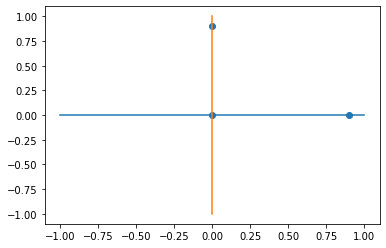

In [282]:
plt.plot([-1, 1], [0, 0])
plt.plot([0, 0], [-1, 1])
plt.scatter(all_v[:, 0], all_v[:, 1])

In [283]:
d12 = ddist(v1, v2)
d13 = ddist(v1, v3)
d23 = ddist(v2, v3)

In [284]:
print("Euclidean distances - d12: {}, d13: {}, d23: {}".format(d12, d13, d23))

Euclidean distances - d12: 0.9, d13: 0.9, d23: 1.2727922061357855


In [285]:
h12 = hdist(v1, v2)
h13 = hdist(v1, v3)
h23 = hdist(v2, v3)

In [292]:
epsilon = 1e-7
def torch_hdist(u, v):
        sqdist = torch.sum((u - v) ** 2, dim=-1)
        squnorm = torch.sum(u ** 2, dim=-1)
        sqvnorm = torch.sum(v ** 2, dim=-1)
        x = 1 + 2 * sqdist / ((1 - squnorm) * (1 - sqvnorm)) + epsilon
        z = torch.sqrt(x ** 2 - 1)
        return torch.log(x + z)

In [293]:
torch_hdist(torch.from_numpy(v1), torch.from_numpy(v2))

tensor(2.9444, dtype=torch.float64)

In [294]:
print("Hyperbolic distances - h12: {}, h13: {}, h23: {}".format(h12, h13, h23))
print("Flat geodesic h23 would be: {}".format(np.sqrt(h12**2 + h13**2)))

Hyperbolic distances - h12: 2.9444389791664407, h13: 2.9444389791664407, h23: 5.201232927686145
Flat geodesic h23 would be: 4.164065537917171


## Hyperbolic Model

In [3]:
sys.path.append("../../lightning_modules/")
from utils import build_knn, graph_intersection, split_datasets, make_mlp
import logging
import torch.nn as nn

In [4]:
class EmbeddingBase(LightningModule):
    def __init__(self, hparams):
        super().__init__()
        """
        Initialise the Lightning Module that can scan over different embedding training regimes
        """
        self.save_hyperparameters()
        # Assign hyperparameters
        self.hparams = hparams

    def setup(self, stage):
        if stage == "fit":
            self.trainset, self.valset, self.testset = split_datasets(
                self.hparams["input_dir"],
                self.hparams["datatype_split"],
                self.hparams["pt_min"],
            )

    def train_dataloader(self):
        if len(self.trainset) > 0:
            return DataLoader(self.trainset, batch_size=1, num_workers=1)
        else:
            return None

    def val_dataloader(self):
        if len(self.valset) > 0:
            return DataLoader(self.valset, batch_size=1, num_workers=1)
        else:
            return None

    def test_dataloader(self):
        if len(self.testset):
            return DataLoader(self.testset, batch_size=1, num_workers=1)
        else:
            return None

    def configure_optimizers(self):
        optimizer = [
            torch.optim.AdamW(
                self.parameters(),
                lr=(self.hparams["lr"]),
                betas=(0.9, 0.999),
                eps=1e-08,
                amsgrad=True,
            )
        ]
        scheduler = [{
            "scheduler":
            torch.optim.lr_scheduler.StepLR(
                optimizer[0],
                step_size=self.hparams["patience"],
                gamma=self.hparams["factor"],
            ),
            "interval":
            "epoch",
            "frequency":
            1,
        }]
        #         scheduler = [torch.optim.lr_scheduler.StepLR(optimizer[0], step_size=1, gamma=0.3)]
        return optimizer, scheduler

    def torch_hdist(self, u, v):
        sqdist = torch.sum((u - v)**2, dim=-1)
        squnorm = torch.sum(u**2, dim=-1)
        sqvnorm = torch.sum(v**2, dim=-1)
        x = 1 + 2 * sqdist / ((1 - squnorm) *
                              (1 - sqvnorm)) + self.hparams["epsilon"]
        z = torch.sqrt(x**2 - 1)
        return torch.log(x + z)

    def training_step(self, batch, batch_idx):
        """
        Args:
            batch (``list``, required): A list of ``torch.tensor`` objects
            batch (``int``, required): The index of the batch

        Returns:
            ``torch.tensor`` The loss function as a tensor
        """

        # Forward pass of model, handling whether Cell Information (ci) is included
        if "ci" in self.hparams["regime"]:
            spatial = self(torch.cat([batch.cell_data, batch.x], axis=-1))
        else:
            spatial = self(batch.x)

        # Instantiate bidirectional truth (since KNN prediction will be bidirectional)
        e_bidir = torch.cat(
            [batch.layerless_true_edges,
             batch.layerless_true_edges.flip(0)],
            axis=-1)

        # Instantiate empty prediction edge list
        e_spatial = torch.empty([2, 0], dtype=torch.int64, device=self.device)

        # Append random edges pairs (rp) for stability
        if "rp" in self.hparams["regime"]:
            n_random = int(self.hparams["randomisation"] * e_bidir.shape[1])
            e_spatial = torch.cat(
                [
                    e_spatial,
                    torch.randint(e_bidir.min(),
                                  e_bidir.max(), (2, n_random),
                                  device=self.device),
                ],
                axis=-1,
            )

        # Append Hard Negative Mining (hnm) with KNN graph
        if "hnm" in self.hparams["regime"]:
            knn_edges = build_knn(spatial, self.hparams["knn"])
            
            print(knn_edges)
            e_spatial = torch.cat(
                [
                    e_spatial,
                    knn_edges,
                ],
                axis=-1,
            )

        # Calculate truth from intersection between Prediction graph and Truth graph
        if "weighting" in self.hparams["regime"]:
            weights_bidir = torch.cat([batch.weights, batch.weights])
            e_spatial, y_cluster, new_weights = graph_intersection(
                e_spatial,
                e_bidir,
                using_weights=True,
                weights_bidir=weights_bidir)
            new_weights = (new_weights.to(self.device) * self.hparams["weight"]
                           )  # Weight positive examples
        else:
            e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)
            new_weights = y_cluster.to(self.device) * self.hparams["weight"]

        # Append all positive examples and their truth and weighting
        e_spatial = torch.cat(
            [
                e_spatial.to(self.device),
                e_bidir.transpose(0, 1).repeat(1, 1).view(-1, 2).transpose(
                    0, 1),
            ],
            axis=-1,
        )
        y_cluster = torch.cat([y_cluster.int(), torch.ones(e_bidir.shape[1])])
        if "weighting" in self.hparams["regime"]:
            new_weights = torch.cat(
                [new_weights, weights_bidir * self.hparams["weight"]])
        else:
            new_weights = torch.cat([
                new_weights,
                torch.ones(e_bidir.shape[1], device=self.device) *
                self.hparams["weight"],
            ])

        hinge = y_cluster.float().to(self.device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = self.torch_hdist(reference, neighbors)
#         print(spatial.max(dim=0))

        new_weights[
            y_cluster ==
            0] = 1  # Give negative examples a weight of 1 (note that there may still be TRUE examples that are weightless)
        d = d * new_weights

        loss = torch.nn.functional.hinge_embedding_loss(
            d, hinge, margin=self.hparams["margin"], reduction="mean")

        self.log("train_loss", loss)

        return loss

    def shared_evaluation(self,
                          batch,
                          batch_idx,
                          knn_radius,
                          knn_num,
                          log=False):

        if "ci" in self.hparams["regime"]:
            spatial = self(torch.cat([batch.cell_data, batch.x], axis=-1))
        else:
            spatial = self(batch.x)

        e_bidir = torch.cat(
            [batch.layerless_true_edges,
             batch.layerless_true_edges.flip(0)],
            axis=-1)

        # Build whole KNN graph
        e_spatial = build_knn(spatial, knn_num)

        e_spatial = e_spatial.to(self.device)
        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = self.torch_hdist(reference, neighbors)

        h_radius = d < knn_radius

        e_spatial = e_spatial[:, h_radius]
        d = d[h_radius]

        if "weighting" in self.hparams["regime"]:
            weights_bidir = torch.cat([batch.weights, batch.weights])
            e_spatial, y_cluster, new_weights = graph_intersection(
                e_spatial,
                e_bidir,
                using_weights=True,
                weights_bidir=weights_bidir)
            new_weights = (new_weights.to(self.device) * self.hparams["weight"]
                           )  # Weight positive examples
        else:
            e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)
            new_weights = y_cluster.to(self.device) * self.hparams["weight"]

        hinge = y_cluster.float().to(self.device)
        hinge[hinge == 0] = -1

        new_weights[y_cluster == -1] = 1
        d = d * new_weights

        loss = torch.nn.functional.hinge_embedding_loss(
            d, hinge, margin=self.hparams["margin"], reduction="mean")

        cluster_true = e_bidir.shape[1]
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])

        eff = torch.tensor(cluster_true_positive / cluster_true)
        pur = torch.tensor(cluster_true_positive / cluster_positive)

        current_lr = self.optimizers().param_groups[0]["lr"]
        if log:
            self.log_dict({
                "val_loss": loss,
                "eff": eff,
                "pur": pur,
                "current_lr": current_lr
            })
        logging.info("Efficiency: {}".format(eff))
        logging.info("Purity: {}".format(pur))
        logging.info(batch.event_file)

        return {
            "loss": loss,
            "preds": e_spatial.cpu().numpy(),
            "truth": y_cluster.cpu().numpy(),
            "truth_graph": e_bidir.cpu().numpy(),
        }

    def validation_step(self, batch, batch_idx):
        """
        Step to evaluate the model's performance
        """

        outputs = self.shared_evaluation(batch,
                                         batch_idx,
                                         self.hparams["r_val"],
                                         100,
                                         log=True)

        return outputs["loss"]

    def test_step(self, batch, batch_idx):
        """
        Step to evaluate the model's performance
        """
        outputs = self.shared_evaluation(batch,
                                         batch_idx,
                                         self.hparams["r_test"],
                                         200,
                                         log=False)

        return outputs

    def optimizer_step(
            self,
            epoch,
            batch_idx,
            optimizer,
            optimizer_idx,
            optimizer_closure=None,
            on_tpu=False,
            using_native_amp=False,
            using_lbfgs=False,
    ):
        """
        Use this to manually enforce warm-up. In the future, this may become built-into PyLightning
        """

        # warm up lr
        if (self.hparams["warmup"] is not None) and (self.trainer.global_step <
                                                     self.hparams["warmup"]):
            lr_scale = min(
                1.0,
                float(self.trainer.global_step + 1) / self.hparams["warmup"])
            for pg in optimizer.param_groups:
                pg["lr"] = lr_scale * self.hparams["lr"]

        # update params
        optimizer.step(closure=optimizer_closure)
        optimizer.zero_grad()

In [5]:
class HyperbolicEmbedding(EmbeddingBase):
    def __init__(self, hparams):
        super().__init__(hparams)
        """
        Initialise the Lightning Module that can scan over different embedding training regimes
        """

        # Construct the MLP architecture
        self.emb_network = make_mlp(
            hparams["in_channels"],
            [hparams["emb_hidden"]] * hparams["nb_layer"] + [hparams["emb_dim"]],
            hidden_activation="Tanh",
            output_activation=None,
            layer_norm=False,
        )

        self.save_hyperparameters()

    def forward(self, x):
        #
        x = self.emb_network(x)

        if "norm" in self.hparams["regime"]:
            x = F.tanh(x) * 0.7

        return x

# Hyperbolic Embedding

In [6]:
with open("../../lightning_modules/Embedding/train_coda_hyper_embedding.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

In [7]:
model = HyperbolicEmbedding(hparams)
wandb_logger = WandbLogger(project='End2End-HyperbolicEmbedding')
wandb_logger.watch(model)
wandb_logger.log_hyperparams({"model": type(model)})
trainer = Trainer(gpus=1, max_epochs=10, logger=wandb_logger, num_sanity_val_steps=0)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [8]:
trainer.fit(model)

Set SLURM handle signals.

  | Name        | Type       | Params
-------------------------------------------
0 | emb_network | Sequential | 794 K 
-------------------------------------------
794 K     Trainable params
0         Non-trainable params
794 K     Total params
3.176     Total estimated model params size (MB)
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value o

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([[-0.0059, -0.0050, -0.0178,  ..., -0.0184, -0.0665, -0.0329],
        [-0.0059, -0.0050, -0.0178,  ..., -0.0184, -0.0665, -0.0329],
        [ 0.0128,  0.0052, -0.0111,  ..., -0.0011, -0.0658, -0.0390],
        ...,
        [ 0.0013,  0.0208, -0.0218,  ..., -0.0131, -0.1366, -0.0964],
        [-0.0024,  0.0199, -0.0233,  ..., -0.0174, -0.1380, -0.0971],
        [ 0.0085,  0.0171, -0.0194,  ...,  0.0041, -0.1257, -0.0976]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1513,     1,  ...,  2422,  2470,   638],
        [ 1513,     1,     0,  ...,  2470,  2422,   638],
        [    2,   125,    65,  ...,   408,   271,   218],
        ...,
        [12489, 12393, 12454,  ...,  9564, 12457, 12400],
        [12490, 12429, 12483,  ..., 11885, 12114, 12156],
        [12491, 12487, 12486,  ..., 11804, 12151, 11818]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12491, 12491, 12491],
        [ 1513,     1,  1196,  ..., 11804, 12151, 11818]], device='cuda:0')
tenso

tensor([[ 0.0052,  0.0011, -0.0150,  ..., -0.0071, -0.0742, -0.0415],
        [ 0.0157,  0.0060, -0.0103,  ...,  0.0034, -0.0721, -0.0417],
        [ 0.0373,  0.0185,  0.0041,  ...,  0.0265, -0.0535, -0.0368],
        ...,
        [ 0.0054,  0.0179, -0.0210,  ..., -0.0007, -0.1282, -0.0986],
        [ 0.0444,  0.0113,  0.0228,  ...,  0.0115,  0.0319,  0.0261],
        [ 0.0444,  0.0113,  0.0228,  ...,  0.0115,  0.0320,  0.0261]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1680,  1710,  ...,   806,   138,  1214],
        [    1,     6,  1666,  ...,   340,  1367,   116],
        [    2,  2085,  1998,  ...,   291,  1488,   959],
        ...,
        [10132, 10106, 10100,  ..., 10034,  9509,  9787],
        [10133, 10134, 10124,  ...,  9680,  9676,  9648],
        [10134, 10133, 10124,  ...,  9680,  9995,  9648]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 10134, 10134, 10134],
        [ 1680,  1710,  1143,  ...,  9680,  9995,  9648]], device='cuda:0')
tenso

tensor([[ 1.4549e-02,  6.5489e-03, -1.1146e-02,  ...,  1.5868e-03,
         -6.9465e-02, -4.3109e-02],
        [-1.3106e-02, -7.7978e-03, -2.1028e-02,  ..., -2.3556e-02,
         -7.2380e-02, -3.5961e-02],
        [-1.3061e-02, -7.7763e-03, -2.1014e-02,  ..., -2.3521e-02,
         -7.2376e-02, -3.5969e-02],
        ...,
        [ 2.1848e-05,  2.0550e-02, -2.2213e-02,  ..., -1.4780e-02,
         -1.3799e-01, -9.6671e-02],
        [ 4.3509e-02,  1.1605e-02,  2.2388e-02,  ...,  1.0704e-02,
          3.2345e-02,  2.7088e-02],
        [ 7.1173e-03,  1.7498e-02, -2.0247e-02,  ...,  2.1456e-03,
         -1.2735e-01, -9.8472e-02]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   258,   182,  ...,  1524,  1570,   189],
        [    1,     2,    97,  ...,    82,  1126,   284],
        [    2,     1,    97,  ...,    82,  1126,  1142],
        ...,
        [14290, 14263, 14228,  ..., 14062, 13735, 13812],
        [14291, 14162, 14174,  ..., 14264, 14257, 14265],
        [14292, 14173, 1

tensor([[ 0.0291,  0.0155, -0.0045,  ...,  0.0206, -0.0697, -0.0500],
        [ 0.0352,  0.0176,  0.0037,  ...,  0.0214, -0.0470, -0.0332],
        [ 0.0093,  0.0004, -0.0105,  ..., -0.0041, -0.0642, -0.0273],
        ...,
        [ 0.0004,  0.0204, -0.0228,  ..., -0.0129, -0.1373, -0.0984],
        [ 0.0100,  0.0145, -0.0181,  ...,  0.0102, -0.1230, -0.0984],
        [ 0.0100,  0.0145, -0.0181,  ...,  0.0101, -0.1230, -0.0984]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[2239,    0,    8,  ...,  218, 2229, 2369],
        [   1, 2893, 3055,  ..., 3218, 3158, 2061],
        [   2,    3,   10,  ..., 2752, 3806, 3160],
        ...,
        [9900, 9890, 9894,  ..., 9469, 9357, 9454],
        [9901, 9902, 9864,  ..., 9785, 9784, 9304],
        [9902, 9901, 9864,  ..., 9784, 9264, 9304]], device='cuda:0')
tensor([[   0,    0,    0,  ..., 9902, 9902, 9902],
        [2239,    8,    9,  ..., 9784, 9264, 9304]], device='cuda:0')
tensor([[ 1.9327e-02,  8.9637e-03, -8.4325e-03,  ...,

tensor([[ 0.0334,  0.0172, -0.0007,  ...,  0.0247, -0.0640, -0.0456],
        [-0.0107, -0.0057, -0.0211,  ..., -0.0212, -0.0777, -0.0414],
        [ 0.0233,  0.0102, -0.0059,  ...,  0.0105, -0.0647, -0.0395],
        ...,
        [ 0.0246,  0.0165,  0.0074,  ...,  0.0024,  0.0204,  0.0373],
        [ 0.0032,  0.0156, -0.0215,  ...,  0.0012, -0.1282, -0.1016],
        [-0.0074,  0.0178, -0.0252,  ..., -0.0222, -0.1419, -0.0979]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1559,   793,  ...,   456,   167,  1753],
        [    1,   728,   778,  ...,  1398,   890,  1406],
        [    2,  2568,  1538,  ...,   882,  1440,   874],
        ...,
        [14886, 14882, 14865,  ..., 14505, 14574, 14736],
        [14887, 14567, 14869,  ..., 14583, 14661, 14758],
        [14888, 14753, 14774,  ..., 14116, 14618, 14863]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14888, 14888, 14888],
        [ 1559,   793,  1906,  ..., 14116, 14618, 14863]], device='cuda:0')
tenso

tensor([[ 0.0418,  0.0193,  0.0130,  ...,  0.0223, -0.0245, -0.0197],
        [ 0.0029, -0.0012, -0.0140,  ..., -0.0111, -0.0639, -0.0306],
        [ 0.0419,  0.0193,  0.0132,  ...,  0.0224, -0.0243, -0.0196],
        ...,
        [-0.0057,  0.0185, -0.0235,  ..., -0.0216, -0.1440, -0.0960],
        [-0.0083,  0.0173, -0.0240,  ..., -0.0244, -0.1450, -0.0946],
        [ 0.0312,  0.0168,  0.0119,  ...,  0.0056,  0.0254,  0.0363]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     2,  7285,  ...,  7223,  6701,  6754],
        [    1,     7,  2950,  ...,  2299,  2380,  3921],
        [    2,     0,  7285,  ...,  7223,  6701,  6754],
        ...,
        [12929, 12832, 12772,  ..., 12572, 12569, 12711],
        [12930, 12885, 12814,  ..., 12521, 12054, 11160],
        [12931, 12859, 12872,  ..., 12465, 12571, 12520]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12931, 12931, 12931],
        [    2,  7285,  7275,  ..., 12465, 12571, 12520]], device='cuda:0')
tenso

tensor([[ 0.0404,  0.0186,  0.0106,  ...,  0.0221, -0.0305, -0.0217],
        [-0.0056, -0.0041, -0.0186,  ..., -0.0179, -0.0716, -0.0368],
        [ 0.0404,  0.0186,  0.0107,  ...,  0.0221, -0.0303, -0.0216],
        ...,
        [ 0.0369,  0.0164,  0.0153,  ...,  0.0084,  0.0288,  0.0359],
        [ 0.0359,  0.0164,  0.0149,  ...,  0.0076,  0.0287,  0.0364],
        [ 0.0044,  0.0197, -0.0223,  ..., -0.0040, -0.1362, -0.1015]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  6532,     2,  ...,  5651,  6797,  5131],
        [    1,     5,   464,  ...,   592,   335,   760],
        [    2,  6579,     0,  ...,  7084,  5571,  4796],
        ...,
        [13138, 13109, 13129,  ..., 12535, 12756, 12751],
        [13139, 12951, 13138,  ..., 12627, 12521, 12899],
        [13140, 13080, 13084,  ..., 13044,  7781, 12903]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13140, 13140, 13140],
        [ 6532,     2,  6579,  ..., 13044,  7781, 12903]], device='cuda:0')
tenso

tensor([[    0,     0,     0,  ..., 13744, 13744, 13744],
        [  233,   196,  1712,  ..., 13691, 13509, 13520]], device='cuda:0')
tensor([[ 0.0481,  0.0213,  0.0178,  ...,  0.0293, -0.0228, -0.0188],
        [ 0.0335,  0.0157,  0.0004,  ...,  0.0218, -0.0584, -0.0390],
        [ 0.0061,  0.0062, -0.0195,  ..., -0.0011, -0.1033, -0.0718],
        ...,
        [ 0.0002,  0.0197, -0.0244,  ..., -0.0094, -0.1406, -0.1037],
        [ 0.0508,  0.0092,  0.0303,  ...,  0.0125,  0.0397,  0.0304],
        [ 0.0508,  0.0092,  0.0303,  ...,  0.0124,  0.0399,  0.0306]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     5,  4571,  ...,  8440,  9238,  8503],
        [    1,  2139,  2110,  ...,  1249,  1200,  3049],
        [    2,     7,  7942,  ...,  9094,  8528,  9131],
        ...,
        [14544, 14542, 14446,  ..., 14497, 14431, 13967],
        [14545, 14546, 14539,  ..., 14024, 14438, 13453],
        [14546, 14545, 14539,  ..., 13855, 14024, 13453]], device='cuda:0')
tenso

tensor([[ 0.0072,  0.0019, -0.0136,  ..., -0.0065, -0.0693, -0.0378],
        [ 0.0292,  0.0141, -0.0039,  ...,  0.0186, -0.0663, -0.0457],
        [ 0.0444,  0.0196,  0.0095,  ...,  0.0338, -0.0509, -0.0336],
        ...,
        [ 0.0416,  0.0148,  0.0206,  ...,  0.0085,  0.0350,  0.0383],
        [ 0.0093,  0.0150, -0.0200,  ...,  0.0116, -0.1302, -0.1053],
        [ 0.0093,  0.0150, -0.0200,  ...,  0.0116, -0.1302, -0.1054]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   769,  1816,  ...,  1070,  1326,  1091],
        [    1,  1076,   910,  ...,   170,    35,    40],
        [    2,     3,  4629,  ...,  2042,  3051,  3214],
        ...,
        [14799, 14773, 14792,  ..., 14107, 14239, 14761],
        [14800, 14801, 14775,  ..., 14172, 14226, 14149],
        [14801, 14800, 14775,  ..., 14172, 14226, 14149]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14801, 14801, 14801],
        [  769,  1816,    72,  ..., 14172, 14226, 14149]], device='cuda:0')
tenso

tensor([[ 0.0114,  0.0049, -0.0131,  ..., -0.0013, -0.0729, -0.0447],
        [ 0.0379,  0.0188,  0.0024,  ...,  0.0284, -0.0582, -0.0435],
        [ 0.0334,  0.0128, -0.0014,  ...,  0.0269, -0.0788, -0.0500],
        ...,
        [ 0.0322,  0.0173,  0.0134,  ...,  0.0036,  0.0290,  0.0458],
        [ 0.0072,  0.0163, -0.0219,  ...,  0.0079, -0.1350, -0.1077],
        [-0.0117,  0.0157, -0.0267,  ..., -0.0251, -0.1524, -0.0990]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     4,   621,  ...,   635,   647,    97],
        [    1,  1236,   917,  ...,   945,  1268,  1483],
        [    2,  3813,  4135,  ...,  3777,  3489,  3350],
        ...,
        [12505, 12411, 12494,  ..., 12269, 11994, 12491],
        [12506, 12485, 11456,  ..., 12041, 12365, 11897],
        [12507, 12469, 11454,  ..., 10971, 10961,  8857]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12507, 12507, 12507],
        [    4,   621,   604,  ..., 10971, 10961,  8857]], device='cuda:0')
tenso

tensor([[ 0.0075,  0.0036, -0.0165,  ..., -0.0025, -0.0869, -0.0538],
        [ 0.0100,  0.0044, -0.0139,  ..., -0.0024, -0.0746, -0.0456],
        [ 0.0434,  0.0222,  0.0059,  ...,  0.0371, -0.0575, -0.0471],
        ...,
        [ 0.0352,  0.0166,  0.0169,  ...,  0.0032,  0.0338,  0.0470],
        [ 0.0049,  0.0183, -0.0236,  ...,  0.0020, -0.1414, -0.1087],
        [ 0.0526,  0.0113,  0.0311,  ...,  0.0128,  0.0428,  0.0376]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  2829,  3131,  ...,  3417,  2081,  4087],
        [    1,  1293,   969,  ...,   914,   415,  1055],
        [    2,   837,  1019,  ...,   933,   296,   420],
        ...,
        [12804, 12803, 12695,  ..., 12213, 12330, 12207],
        [12805, 12667, 12670,  ..., 12299, 12167, 12445],
        [12806, 12789, 12786,  ..., 12328, 12270, 12535]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12806, 12806, 12806],
        [ 2829,  3131,  3303,  ..., 12328, 12270, 12535]], device='cuda:0')
tenso

tensor([[ 0.0056,  0.0071, -0.0216,  ...,  0.0017, -0.1089, -0.0821],
        [-0.0258, -0.0065, -0.0307,  ..., -0.0308, -0.1067, -0.0629],
        [-0.0195, -0.0106, -0.0237,  ..., -0.0310, -0.0733, -0.0304],
        ...,
        [ 0.0314,  0.0177,  0.0138,  ...,  0.0011,  0.0304,  0.0523],
        [ 0.0278,  0.0172,  0.0118,  ..., -0.0013,  0.0284,  0.0537],
        [ 0.0278,  0.0172,  0.0118,  ..., -0.0013,  0.0285,  0.0537]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,    10,  9131,  ...,  9362,  9211,  9170],
        [    1,  6738,    11,  ...,  7327,  5994,  5989],
        [    2,  1849,   538,  ...,   207,  1116,  1126],
        ...,
        [14571, 14510, 14513,  ..., 13957, 13880, 14567],
        [14572, 14573, 13622,  ..., 13835, 14498, 14490],
        [14573, 14572, 13622,  ..., 13078, 13836, 13835]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14573, 14573, 14573],
        [   10,  9131,  9163,  ..., 13078, 13836, 13835]], device='cuda:0')
tenso

tensor([[ 0.0364,  0.0170,  0.0037,  ...,  0.0211, -0.0460, -0.0330],
        [-0.0026, -0.0048, -0.0122,  ..., -0.0228, -0.0409, -0.0057],
        [-0.0100, -0.0058, -0.0207,  ..., -0.0227, -0.0740, -0.0350],
        ...,
        [-0.0051,  0.0181, -0.0279,  ..., -0.0129, -0.1527, -0.1098],
        [-0.0078,  0.0174, -0.0281,  ..., -0.0172, -0.1549, -0.1076],
        [ 0.0547,  0.0118,  0.0330,  ...,  0.0131,  0.0451,  0.0407]],
       device='cuda:0')
tensor([[    0,  3605,  4739,  ...,  4904,  4553,  4255],
        [    1,  7955,  7949,  ...,  7258,  8245,  7920],
        [    2,   744,   768,  ...,  1151,   375,   341],
        ...,
        [17433, 17432, 17399,  ..., 17090, 17130, 17120],
        [17434, 17427, 17400,  ..., 17109, 17095, 16734],
        [17435, 17379, 17297,  ..., 17294, 17355, 17358]], device='cuda:0')


/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[-0.0095, -0.0009, -0.0247,  ..., -0.0158, -0.1154, -0.0685],
        [ 0.0374,  0.0184,  0.0017,  ...,  0.0270, -0.0573, -0.0443],
        [-0.0137, -0.0080, -0.0217,  ..., -0.0259, -0.0740, -0.0319],
        ...,
        [ 0.0459,  0.0144,  0.0263,  ...,  0.0070,  0.0429,  0.0458],
        [ 0.0330,  0.0171,  0.0161,  ...,  0.0005,  0.0340,  0.0526],
        [ 0.0331,  0.0171,  0.0161,  ...,  0.0005,  0.0340,  0.0526]],
       device='cuda:0')
tensor([[    0,     6,  8619,  ...,  9173,  8613,  6810],
        [    1,   158,   178,  ...,   920,  1025,   955],
        [    2,   143,   762,  ...,  1751,  2556,   872],
        ...,
        [13700, 13696, 13693,  ..., 12997, 13304, 13257],
        [13701, 13702, 13689,  ..., 13085, 13391, 13112],
        [13702, 13701, 13689,  ..., 13391, 13085, 13248]], device='cuda:0')
tensor([[ 2.0799e-03, -1.3973e-04, -1.6474e-02,  ..., -1.0900e-02,
         -7.4769e-02, -3.9849e-02],
        [ 2.0692e-02,  9.5874e-03, -8.8478e-03,  ...,  8.730

tensor([[-8.0041e-03,  4.0340e-04, -2.5490e-02,  ..., -1.4359e-02,
         -1.0566e-01, -6.9865e-02],
        [ 2.8291e-02,  1.2474e-02, -4.3233e-03,  ...,  1.7230e-02,
         -6.7748e-02, -4.5000e-02],
        [-8.8369e-03,  8.3609e-05, -2.5765e-02,  ..., -1.5172e-02,
         -1.0583e-01, -6.9627e-02],
        ...,
        [ 2.8545e-02,  1.7479e-02,  1.2433e-02,  ..., -1.3578e-03,
          2.9188e-02,  5.5036e-02],
        [ 5.7697e-02,  1.0098e-02,  3.6796e-02,  ...,  1.4082e-02,
          4.7995e-02,  3.8905e-02],
        [ 4.5568e-02,  1.5304e-02,  2.4866e-02,  ...,  7.6253e-03,
          4.1132e-02,  4.6754e-02]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     2,  7375,  ...,  6080,  7565,  7856],
        [    1,     5,  1795,  ...,  1595,  1534,  2376],
        [    2,  7375,  7327,  ...,  6678,  6685,  6137],
        ...,
        [15282, 15273, 15214,  ..., 14588, 14750, 15079],
        [15283, 15281, 15280,  ..., 14848, 14507, 14771],
        [15284, 15237, 1

tensor([[ 3.2568e-03,  1.3347e-04, -1.5941e-02,  ..., -9.6476e-03,
         -7.5957e-02, -3.9392e-02],
        [ 1.6560e-02,  5.8623e-03, -9.7991e-03,  ...,  3.9152e-03,
         -7.3005e-02, -4.0846e-02],
        [ 4.5204e-02,  2.0915e-02,  8.2779e-03,  ...,  3.4362e-02,
         -4.9856e-02, -3.8784e-02],
        ...,
        [ 3.9330e-03,  1.6369e-02, -2.5335e-02,  ...,  6.9512e-03,
         -1.4471e-01, -1.1605e-01],
        [ 5.2801e-02,  1.3485e-02,  3.1533e-02,  ...,  1.0783e-02,
          4.6053e-02,  4.5619e-02],
        [ 5.2804e-02,  1.3476e-02,  3.1533e-02,  ...,  1.0774e-02,
          4.6114e-02,  4.5657e-02]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1143,  1680,  ...,  1214,  1581,   510],
        [    1,     6,  1666,  ...,  1703,  1205,  1239],
        [    2,  2085,  1998,  ...,   205,   189,  1892],
        ...,
        [10132, 10106, 10100,  ...,  9685,  9989,  9767],
        [10133, 10134, 10124,  ..., 10107,  9929,  9906],
        [10134, 10133, 1

tensor([[ 0.0155,  0.0066, -0.0109,  ...,  0.0024, -0.0697, -0.0432],
        [-0.0203, -0.0103, -0.0245,  ..., -0.0325, -0.0754, -0.0302],
        [-0.0202, -0.0103, -0.0245,  ..., -0.0325, -0.0754, -0.0302],
        ...,
        [-0.0057,  0.0172, -0.0290,  ..., -0.0110, -0.1583, -0.1132],
        [ 0.0528,  0.0142,  0.0323,  ...,  0.0092,  0.0483,  0.0495],
        [ 0.0062,  0.0157, -0.0247,  ...,  0.0118, -0.1459, -0.1182]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   258,   475,  ...,  1140,   169,   189],
        [    1,     2,    97,  ...,  1690,  1142,  2111],
        [    2,     1,    97,  ...,    82,  2111,  1690],
        ...,
        [14290, 14263, 14219,  ..., 14016, 14169, 13800],
        [14291, 14162, 14174,  ..., 14026, 13638, 13739],
        [14292, 14173, 11174,  ..., 13893, 14034, 13928]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14292, 14292, 14292],
        [  258,   475,   182,  ..., 13893, 14034, 13928]], device='cuda:0')
tenso

tensor([[ 0.0401,  0.0192,  0.0019,  ...,  0.0321, -0.0609, -0.0509],
        [-0.0149, -0.0086, -0.0215,  ..., -0.0294, -0.0698, -0.0244],
        [ 0.0028,  0.0044, -0.0225,  ..., -0.0016, -0.1047, -0.0756],
        ...,
        [-0.0173,  0.0128, -0.0321,  ..., -0.0246, -0.1659, -0.1082],
        [ 0.0054,  0.0148, -0.0255,  ...,  0.0136, -0.1475, -0.1217],
        [ 0.0055,  0.0149, -0.0255,  ...,  0.0137, -0.1476, -0.1217]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   157,   514,  ...,  1013,   915,   224],
        [    1,   852,   196,  ...,  3622,  2463,  3275],
        [    2,  7287,     3,  ...,  8304,  7228,  8215],
        ...,
        [13478, 13360, 13236,  ..., 13382, 13358, 12808],
        [13479, 13480, 13381,  ..., 12872, 12914, 13115],
        [13480, 13479, 13381,  ..., 12872, 12914, 13082]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13480, 13480, 13480],
        [  157,   514,   383,  ..., 12872, 12914, 13082]], device='cuda:0')
tenso

tensor([[ 0.0233,  0.0122, -0.0140,  ...,  0.0274, -0.1034, -0.0902],
        [ 0.0232,  0.0121, -0.0140,  ...,  0.0273, -0.1035, -0.0902],
        [ 0.0430,  0.0200,  0.0047,  ...,  0.0332, -0.0541, -0.0462],
        ...,
        [ 0.0427,  0.0186,  0.0246,  ...,  0.0004,  0.0438,  0.0643],
        [ 0.0427,  0.0186,  0.0246,  ...,  0.0004,  0.0438,  0.0644],
        [ 0.0579,  0.0147,  0.0373,  ...,  0.0100,  0.0534,  0.0543]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     1,  9090,  ..., 10518,  9446,  9643],
        [    1,     0,  8973,  ...,  9616,  8621,  9643],
        [    2,     5,   280,  ...,   276,   506,   798],
        ...,
        [13855, 13856, 13839,  ..., 13449, 13578, 13457],
        [13856, 13855, 13839,  ..., 13421, 13578, 13457],
        [13857, 13766, 13809,  ..., 10544, 13408, 13188]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13857, 13857, 13857],
        [    1,  9090,  8973,  ..., 10544, 13408, 13188]], device='cuda:0')
tenso

tensor([[ 0.0184,  0.0033, -0.0008,  ..., -0.0034, -0.0518, -0.0019],
        [-0.0232, -0.0097, -0.0274,  ..., -0.0345, -0.0850, -0.0366],
        [ 0.0006, -0.0004, -0.0175,  ..., -0.0128, -0.0772, -0.0394],
        ...,
        [-0.0050,  0.0119, -0.0317,  ...,  0.0082, -0.1539, -0.1337],
        [ 0.0616,  0.0149,  0.0405,  ...,  0.0114,  0.0558,  0.0561],
        [ 0.0542,  0.0169,  0.0344,  ...,  0.0059,  0.0526,  0.0613]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 5977,     0,  6273,  ...,  5591,  5667,  4299],
        [    1,   179,   276,  ...,  1255,  2114,  2390],
        [    2,   861,   659,  ...,  1805,    90,   566],
        ...,
        [11711, 11708, 10079,  ..., 11191, 11495, 11455],
        [11712, 11710, 11658,  ..., 11668, 11707, 11238],
        [11713, 11707, 11454,  ..., 11418, 11626, 11358]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 11713, 11713, 11713],
        [ 5977,  6273,  6504,  ..., 11418, 11626, 11358]], device='cuda:0')
tenso

tensor([[-0.0147, -0.0067, -0.0231,  ..., -0.0291, -0.0768, -0.0313],
        [-0.0002, -0.0008, -0.0172,  ..., -0.0147, -0.0746, -0.0354],
        [ 0.0540,  0.0241,  0.0115,  ...,  0.0475, -0.0504, -0.0496],
        ...,
        [ 0.0053,  0.0144, -0.0274,  ...,  0.0160, -0.1581, -0.1282],
        [ 0.0391,  0.0173,  0.0290,  ..., -0.0101,  0.0543,  0.0718],
        [ 0.0378,  0.0181,  0.0265,  ..., -0.0099,  0.0505,  0.0734]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   553,   113,  ...,   796,   107,   876],
        [    1,   958,  1012,  ...,  1613,   289,   997],
        [    2,   988,  1186,  ...,   593,   347,   425],
        ...,
        [14321, 14226, 14293,  ..., 14232, 13943, 14211],
        [14322, 14157, 14122,  ..., 14059, 14302, 13753],
        [14323, 14203, 14250,  ..., 14297, 14259, 13611]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14323, 14323, 14323],
        [  553,   113,   519,  ..., 14297, 14259, 13611]], device='cuda:0')
tenso

tensor([[    0,  2551,  2984,  ...,  1620,  2707,  1662],
        [    1,  3658,  2987,  ...,  3518,  2742,  2671],
        [    4,     2,  8233,  ...,  8207,  8198,  8154],
        ...,
        [12387, 12386, 12388,  ..., 12087, 12030, 12020],
        [12388, 12386, 12387,  ..., 12234, 12156, 12092],
        [12389, 12380, 12321,  ..., 11840, 11990, 12025]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12389, 12389, 12389],
        [ 2551,  2984,  2341,  ..., 11840, 11990, 12025]], device='cuda:0')
tensor([[ 0.0127,  0.0051, -0.0113,  ..., -0.0024, -0.0668, -0.0373],
        [-0.0038, -0.0019, -0.0203,  ..., -0.0156, -0.0860, -0.0429],
        [ 0.0176,  0.0073, -0.0099,  ...,  0.0044, -0.0688, -0.0431],
        ...,
        [ 0.0082,  0.0114, -0.0265,  ...,  0.0274, -0.1559, -0.1355],
        [-0.0114,  0.0133, -0.0352,  ..., -0.0075, -0.1731, -0.1268],
        [ 0.0086,  0.0124, -0.0264,  ...,  0.0251, -0.1579, -0.1331]],
       device='cuda:0', grad_fn=<MulBackward0>)
tenso

tensor([[ 0.0467,  0.0199,  0.0040,  ...,  0.0426, -0.0621, -0.0597],
        [ 0.0555,  0.0234,  0.0106,  ...,  0.0522, -0.0553, -0.0572],
        [ 0.0555,  0.0233,  0.0107,  ...,  0.0522, -0.0553, -0.0571],
        ...,
        [ 0.0436,  0.0214,  0.0296,  ..., -0.0090,  0.0510,  0.0828],
        [ 0.0609,  0.0195,  0.0408,  ...,  0.0053,  0.0579,  0.0721],
        [-0.0022,  0.0134, -0.0322,  ...,  0.0083, -0.1704, -0.1326]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   904,   615,  ...,  2095,   985,   286],
        [    1,     2,  1179,  ...,   943,  1602,  1670],
        [    2,     1,  1179,  ...,   943,  1670,  1384],
        ...,
        [15168, 15165, 15139,  ..., 14755, 14570, 14597],
        [15169, 15070, 15146,  ..., 14896, 14621, 14628],
        [15170, 15159, 14913,  ..., 14530, 15026, 14701]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 15170, 15170, 15170],
        [  904,   615,   792,  ..., 14530, 15026, 14701]], device='cuda:0')
tenso

tensor([[ 0.0276,  0.0104, -0.0024,  ...,  0.0117, -0.0600, -0.0340],
        [-0.0213, -0.0089, -0.0239,  ..., -0.0404, -0.0712, -0.0150],
        [ 0.0173,  0.0069, -0.0182,  ...,  0.0222, -0.1115, -0.0909],
        ...,
        [ 0.0008,  0.0116, -0.0321,  ...,  0.0181, -0.1695, -0.1394],
        [ 0.0008,  0.0116, -0.0322,  ...,  0.0181, -0.1695, -0.1394],
        [-0.0180,  0.0101, -0.0387,  ..., -0.0119, -0.1818, -0.1289]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 1103,     0,  1099,  ...,  1762,  1400,  1371],
        [    1,   526,  1257,  ...,   430,  1281,   338],
        [    2,  5957,  5842,  ...,  6578,  4972,  4620],
        ...,
        [10635, 10634, 10636,  ..., 10032, 10633, 10631],
        [10636, 10635, 10634,  ..., 10032, 10633, 10631],
        [10637, 10601, 10604,  ..., 10206, 10569, 10630]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 10637, 10637, 10637],
        [ 1103,  1099,  1074,  ..., 10206, 10569, 10630]], device='cuda:0')
tenso

tensor([[ 0.0335,  0.0133, -0.0038,  ...,  0.0263, -0.0692, -0.0568],
        [ 0.0477,  0.0193,  0.0064,  ...,  0.0390, -0.0532, -0.0506],
        [ 0.0478,  0.0193,  0.0065,  ...,  0.0391, -0.0531, -0.0505],
        ...,
        [-0.0032,  0.0109, -0.0344,  ...,  0.0131, -0.1767, -0.1399],
        [ 0.0303,  0.0228,  0.0241,  ..., -0.0264,  0.0453,  0.1009],
        [ 0.0629,  0.0219,  0.0447,  ...,  0.0011,  0.0631,  0.0813]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1733,   310,  ...,  2267,  1896,  1333],
        [    1,     2,  1233,  ...,   597,   626,  1750],
        [    2,     1,  1233,  ...,   999,   626,  1619],
        ...,
        [13086, 13070, 12920,  ..., 12640, 12819, 12509],
        [13087, 12955, 12960,  ..., 12485, 12653, 12439],
        [13088, 13078, 12917,  ..., 12852, 12953, 12968]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13088, 13088, 13088],
        [ 1733,   310,   668,  ..., 12852, 12953, 12968]], device='cuda:0')
tenso

tensor([[-0.0170, -0.0056, -0.0238,  ..., -0.0354, -0.0756, -0.0235],
        [-0.0002,  0.0006, -0.0178,  ..., -0.0159, -0.0751, -0.0355],
        [-0.0028, -0.0004, -0.0184,  ..., -0.0196, -0.0738, -0.0320],
        ...,
        [ 0.0569,  0.0246,  0.0415,  ..., -0.0074,  0.0611,  0.0916],
        [ 0.0320,  0.0237,  0.0272,  ..., -0.0299,  0.0513,  0.1044],
        [ 0.0519,  0.0250,  0.0384,  ..., -0.0118,  0.0589,  0.0948]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     3,   120,  ...,  1335,  1575,  1489],
        [    1,   312,   912,  ...,   718,   384,   282],
        [    2,     5,   257,  ...,  1447,   567,   340],
        ...,
        [13666, 13636, 13567,  ..., 13389, 12970, 13533],
        [13667, 12210, 13537,  ..., 13329, 13388, 13395],
        [13668, 13447, 13433,  ..., 13421, 13018, 13013]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13668, 13668, 13668],
        [    3,   120,    46,  ..., 13421, 13018, 13013]], device='cuda:0')
tenso

tensor([[ 0.0502,  0.0201,  0.0117,  ...,  0.0339, -0.0376, -0.0346],
        [-0.0106, -0.0025, -0.0127,  ..., -0.0449, -0.0366,  0.0186],
        [-0.0215, -0.0069, -0.0262,  ..., -0.0394, -0.0794, -0.0242],
        ...,
        [-0.0156,  0.0079, -0.0405,  ..., -0.0009, -0.1882, -0.1394],
        [-0.0205,  0.0070, -0.0415,  ..., -0.0087, -0.1911, -0.1348],
        [ 0.0772,  0.0217,  0.0562,  ...,  0.0107,  0.0697,  0.0786]],
       device='cuda:0')
tensor([[    0,  3605,  4739,  ...,  3838,  4904,  2642],
        [    1,  7955,  7949,  ...,  9893,  9112,  8563],
        [    2,   744,   768,  ...,   111,   561,  1635],
        ...,
        [17433, 17432, 17399,  ..., 17392, 17389, 17026],
        [17434, 17400, 17397,  ..., 17172, 16733, 16641],
        [17435, 17379, 17404,  ..., 17299, 16604, 16588]], device='cuda:0')
tensor([[-0.0207, -0.0061, -0.0325,  ..., -0.0214, -0.1353, -0.0731],
        [ 0.0530,  0.0204,  0.0091,  ...,  0.0463, -0.0517, -0.0541],
        [-0.0269, -0.00

tensor([[-0.0210, -0.0069, -0.0241,  ..., -0.0424, -0.0708, -0.0141],
        [-0.0210, -0.0069, -0.0241,  ..., -0.0424, -0.0708, -0.0141],
        [ 0.0134,  0.0057, -0.0105,  ..., -0.0034, -0.0654, -0.0344],
        ...,
        [-0.0114,  0.0086, -0.0380,  ...,  0.0036, -0.1875, -0.1388],
        [-0.0197,  0.0071, -0.0424,  ..., -0.0057, -0.1891, -0.1387],
        [ 0.0095,  0.0071, -0.0289,  ...,  0.0385, -0.1718, -0.1489]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    1,     0,  1513,  ...,  2135,  3120,  2422],
        [    1,     0,  1513,  ...,  2135,  3120,  2422],
        [    2,   125,    65,  ...,   936,  2691,  1194],
        ...,
        [12489, 12393, 12454,  ..., 12387, 12443, 11788],
        [12490, 12429, 12483,  ..., 12159, 12156, 11974],
        [12491, 12486, 12487,  ..., 12031, 12109, 11769]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12491, 12491, 12491],
        [    1,  1513,  1196,  ..., 12031, 12109, 11769]], device='cuda:0')
tenso

tensor([[-0.0015, -0.0003, -0.0180,  ..., -0.0175, -0.0810, -0.0333],
        [ 0.0190,  0.0060, -0.0080,  ...,  0.0053, -0.0760, -0.0390],
        [ 0.0654,  0.0235,  0.0192,  ...,  0.0574, -0.0421, -0.0475],
        ...,
        [ 0.0028,  0.0058, -0.0338,  ...,  0.0337, -0.1781, -0.1540],
        [ 0.0742,  0.0243,  0.0551,  ...,  0.0041,  0.0706,  0.0869],
        [ 0.0742,  0.0243,  0.0551,  ...,  0.0041,  0.0707,  0.0870]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1143,   275,  ...,   686,   534,    94],
        [    1,     6,  1666,  ...,   360,   859,  1123],
        [    2,  2085,  1998,  ...,  1287,   895,  2448],
        ...,
        [10132, 10106, 10100,  ...,  9547, 10102,  9567],
        [10133, 10134, 10124,  ...,  9931,  9844, 10000],
        [10134, 10133, 10124,  ...,  9500, 10000,  9844]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 10134, 10134, 10134],
        [ 1143,   275,   226,  ...,  9500, 10000,  9844]], device='cuda:0')
tenso

tensor([[ 0.0174,  0.0069, -0.0103,  ...,  0.0042, -0.0707, -0.0439],
        [-0.0369, -0.0106, -0.0324,  ..., -0.0572, -0.0830, -0.0144],
        [-0.0368, -0.0105, -0.0323,  ..., -0.0571, -0.0830, -0.0144],
        ...,
        [-0.0164,  0.0049, -0.0416,  ...,  0.0033, -0.1966, -0.1435],
        [ 0.0745,  0.0262,  0.0567,  ...,  0.0005,  0.0734,  0.0926],
        [ 0.0067,  0.0038, -0.0321,  ...,  0.0417, -0.1803, -0.1570]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   258,   475,  ...,   233,  1988,   507],
        [    1,    97,     2,  ...,  2111,  1155,   284],
        [    2,     1,    97,  ...,  2111,  1183,  1155],
        ...,
        [14290, 14263, 14219,  ..., 13805, 13435, 13849],
        [14291, 14162, 14174,  ..., 13443, 14026, 14025],
        [14292, 11174, 14258,  ..., 13403, 13462, 13401]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14292, 14292, 14292],
        [  258,   475,   182,  ..., 13403, 13462, 13401]], device='cuda:0')
tenso

tensor([[ 0.0576,  0.0194,  0.0097,  ...,  0.0569, -0.0563, -0.0657],
        [-0.0288, -0.0074, -0.0271,  ..., -0.0535, -0.0756, -0.0063],
        [-0.0015, -0.0004, -0.0292,  ...,  0.0051, -0.1179, -0.0908],
        ...,
        [-0.0357, -0.0003, -0.0483,  ..., -0.0212, -0.2070, -0.1316],
        [ 0.0059,  0.0014, -0.0334,  ...,  0.0459, -0.1823, -0.1625],
        [ 0.0061,  0.0015, -0.0333,  ...,  0.0459, -0.1825, -0.1624]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   157,   514,  ...,   459,   321,  1532],
        [    1,   852,  1075,  ...,  2611,  2079,  2695],
        [    2,  7287,     3,  ...,  6660,  8245,  8249],
        ...,
        [13478, 13360, 13127,  ..., 13345, 12578, 12661],
        [13479, 13480, 13381,  ..., 13115, 13390, 13025],
        [13480, 13479, 13381,  ..., 13115, 13390, 13025]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13480, 13480, 13480],
        [  157,   514,   383,  ..., 13115, 13390, 13025]], device='cuda:0')
tenso

tensor([[ 1.3282e-02,  3.5685e-03, -1.7165e-02,  ...,  1.0985e-02,
         -9.5023e-02, -6.7596e-02],
        [ 5.7963e-02,  1.8420e-02,  1.1093e-02,  ...,  5.4838e-02,
         -5.5570e-02, -6.0428e-02],
        [ 5.7974e-02,  1.8416e-02,  1.1105e-02,  ...,  5.4848e-02,
         -5.5593e-02, -6.0411e-02],
        ...,
        [ 4.0547e-02,  3.2126e-02,  3.8808e-02,  ..., -4.1065e-02,
          6.2669e-02,  1.2536e-01],
        [-1.9475e-02,  1.0036e-03, -4.6551e-02,  ...,  9.2060e-03,
         -2.0136e-01, -1.5477e-01],
        [-2.8798e-02, -6.4670e-05, -4.9573e-02,  ..., -5.1613e-03,
         -2.0570e-01, -1.4739e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  3564,  3614,  ...,  2573,  2537,  1691],
        [    1,     2,   609,  ...,    91,  1262,  1567],
        [    2,     1,   609,  ...,  1567,    91,  1262],
        ...,
        [10969, 10901, 10897,  ..., 10567, 10603, 10589],
        [10970, 10942, 10782,  ..., 10598, 10608, 10587],
        [10971, 10931, 1

tensor([[-0.0041,  0.0004, -0.0198,  ..., -0.0213, -0.0822, -0.0331],
        [ 0.0141,  0.0056, -0.0127,  ...,  0.0015, -0.0752, -0.0456],
        [-0.0421, -0.0096, -0.0339,  ..., -0.0671, -0.0848, -0.0043],
        ...,
        [-0.0175, -0.0006, -0.0458,  ...,  0.0141, -0.2052, -0.1568],
        [-0.0176, -0.0006, -0.0458,  ...,  0.0142, -0.2053, -0.1569],
        [-0.0176, -0.0006, -0.0458,  ...,  0.0142, -0.2053, -0.1570]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1171,   610,  ...,  1899,  1159,   269],
        [    1,   244,   199,  ...,  1170,   326,  2085],
        [    2,  1343,   701,  ...,   263,  1157,  1192],
        ...,
        [11557, 11558, 11559,  ..., 11496, 11512, 11091],
        [11558, 11559, 11557,  ..., 11496, 11512, 11091],
        [11559, 11558, 11557,  ..., 11496, 11512, 11091]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 11559, 11559, 11559],
        [ 1171,   610,   562,  ..., 11496, 11512, 11091]], device='cuda:0')
tenso

tensor([[ 0.0022,  0.0026, -0.0164,  ..., -0.0157, -0.0782, -0.0325],
        [ 0.0345,  0.0096, -0.0018,  ...,  0.0267, -0.0737, -0.0530],
        [ 0.0625,  0.0188,  0.0133,  ...,  0.0611, -0.0511, -0.0644],
        ...,
        [ 0.0626,  0.0370,  0.0540,  ..., -0.0279,  0.0709,  0.1266],
        [ 0.0924,  0.0311,  0.0735,  ...,  0.0049,  0.0866,  0.1007],
        [ 0.0924,  0.0311,  0.0735,  ...,  0.0049,  0.0866,  0.1009]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1189,   718,  ...,   564,   980,  1361],
        [    1,  1372,  2210,  ...,  1948,  2681,  2072],
        [    2,     5,   293,  ...,   524,   106,   886],
        ...,
        [12646, 12613, 12509,  ..., 12628, 12512, 11954],
        [12647, 12648, 12587,  ..., 12137, 12518, 12200],
        [12648, 12647, 12587,  ..., 12137, 12518, 12200]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12648, 12648, 12648],
        [ 1189,   718,    71,  ..., 12137, 12518, 12200]], device='cuda:0')
tenso

tensor([[-0.0458, -0.0085, -0.0348,  ..., -0.0748, -0.0879,  0.0035],
        [ 0.0465,  0.0127,  0.0039,  ...,  0.0424, -0.0657, -0.0604],
        [ 0.0320,  0.0026, -0.0143,  ...,  0.0532, -0.1096, -0.1100],
        ...,
        [ 0.0561,  0.0401,  0.0523,  ..., -0.0403,  0.0708,  0.1375],
        [ 0.0149, -0.0096, -0.0302,  ...,  0.0733, -0.1928, -0.1779],
        [ 0.0148, -0.0096, -0.0303,  ...,  0.0732, -0.1929, -0.1780]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   726,   711,  ...,   470,  1189,   318],
        [    1,   628,   566,  ...,   724,   413,   304],
        [    2,  5353,  5335,  ...,  4132,  6372,  3581],
        ...,
        [10476, 10474, 10435,  ..., 10025, 10151, 10386],
        [10477, 10478, 10441,  ..., 10040, 10158, 10041],
        [10478, 10477, 10441,  ..., 10131, 10041, 10158]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 10478, 10478, 10478],
        [  726,   711,  1264,  ..., 10131, 10041, 10158]], device='cuda:0')
tenso

tensor([[ 0.0637,  0.0115,  0.0067,  ...,  0.0849, -0.0766, -0.1033],
        [-0.0339, -0.0052, -0.0346,  ..., -0.0539, -0.0947, -0.0241],
        [ 0.0241,  0.0056, -0.0084,  ...,  0.0175, -0.0848, -0.0559],
        ...,
        [ 0.0703,  0.0420,  0.0620,  ..., -0.0305,  0.0754,  0.1361],
        [ 0.0129, -0.0121, -0.0320,  ...,  0.0744, -0.1983, -0.1812],
        [-0.0413, -0.0090, -0.0565,  ..., -0.0097, -0.2270, -0.1497]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  4640,  4108,  ...,  7221,  6717,  4301],
        [    1,  1270,   435,  ...,   749,  1395,  1257],
        [    2,  3321,  3567,  ...,   919,   717,  1336],
        ...,
        [16246, 16245, 16220,  ..., 16241, 16022, 15957],
        [16247, 16196, 16182,  ..., 15691, 16116, 15756],
        [16248, 16226, 16088,  ..., 15992, 16133, 16125]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 16248, 16248, 16248],
        [ 4640,  4108,  2200,  ..., 15992, 16133, 16125]], device='cuda:0')
tenso

tensor([[ 0.0788,  0.0282,  0.0379,  ...,  0.0462, -0.0004, -0.0106],
        [ 0.0240,  0.0078, -0.0076,  ...,  0.0127, -0.0717, -0.0489],
        [ 0.0175, -0.0069, -0.0278,  ...,  0.0563, -0.1380, -0.1409],
        ...,
        [ 0.0866,  0.0425,  0.0739,  ..., -0.0181,  0.0842,  0.1309],
        [ 0.0053, -0.0147, -0.0377,  ...,  0.0696, -0.2065, -0.1856],
        [-0.0196, -0.0106, -0.0487,  ...,  0.0261, -0.2243, -0.1677]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  5063,  5026,  ...,  5393,  4389,  6037],
        [    1,   177,   485,  ...,   465,   756,  1647],
        [    2,     8,  3146,  ...,  8548,  9590,  8522],
        ...,
        [12716, 12710, 12709,  ..., 12092, 12087, 12616],
        [12717, 12715, 12696,  ..., 12203, 12385, 12627],
        [12718, 12115, 12687,  ..., 12470, 12457, 12117]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12718, 12718, 12718],
        [ 5063,  5026,  6208,  ..., 12470, 12457, 12117]], device='cuda:0')
tenso

tensor([[ 0.0885,  0.0077,  0.0292,  ...,  0.1112, -0.0817, -0.0938],
        [ 0.0110, -0.0060, -0.0289,  ...,  0.0387, -0.1290, -0.1205],
        [ 0.0755,  0.0113,  0.0268,  ...,  0.0756, -0.0721, -0.0586],
        ...,
        [ 0.1135,  0.0383,  0.0934,  ...,  0.0100,  0.0998,  0.1117],
        [ 0.1135,  0.0383,  0.0934,  ...,  0.0099,  0.0999,  0.1118],
        [ 0.0034, -0.0181, -0.0394,  ...,  0.0716, -0.2127, -0.1890]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  5251,  5697,  ...,  5940,  4049,  4091],
        [    1,  9059,     8,  ...,  7597,  7527,  7715],
        [    2,    10,  4380,  ...,  3398,  4198,  5356],
        ...,
        [14798, 14799, 14738,  ..., 14362, 14594, 14366],
        [14799, 14798, 14738,  ..., 14594, 14362, 14366],
        [14800, 14797, 14674,  ..., 14764, 14480, 14772]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14800, 14800, 14800],
        [ 5251,  5697,  5738,  ..., 14764, 14480, 14772]], device='cuda:0')
tenso

tensor([[-0.0597, -0.0056, -0.0446,  ..., -0.0906, -0.0968,  0.0024],
        [-0.0265, -0.0009, -0.0316,  ..., -0.0490, -0.0925, -0.0234],
        [ 0.0050,  0.0033, -0.0130,  ..., -0.0159, -0.0886, -0.0273],
        ...,
        [ 0.1081,  0.0442,  0.0917,  ..., -0.0040,  0.0981,  0.1267],
        [ 0.0879,  0.0500,  0.0787,  ..., -0.0297,  0.0869,  0.1465],
        [ 0.1088,  0.0438,  0.0922,  ..., -0.0031,  0.1002,  0.1252]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     3,   191,  ...,  1907,  1622,   264],
        [    1,    44,   774,  ...,   157,    53,   477],
        [    2,  1763,   494,  ...,  2037,  2042,  2116],
        ...,
        [10859, 10861, 10854,  ..., 10504,  2911, 10531],
        [10860, 10824, 10597,  ..., 10542, 10749, 10328],
        [10861, 10859, 10854,  ..., 10759,  2911, 10362]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 10861, 10861, 10861],
        [    3,   191,   516,  ..., 10759,  2911, 10362]], device='cuda:0')
tenso

tensor([[ 0.0698,  0.0210,  0.0247,  ...,  0.0520, -0.0278, -0.0391],
        [-0.0174,  0.0136, -0.0118,  ..., -0.0798, -0.0325,  0.0510],
        [-0.0353, -0.0004, -0.0338,  ..., -0.0646, -0.0892, -0.0088],
        ...,
        [-0.0331, -0.0198, -0.0581,  ...,  0.0220, -0.2410, -0.1745],
        [-0.0407, -0.0194, -0.0602,  ...,  0.0090, -0.2448, -0.1666],
        [ 0.1163,  0.0444,  0.0983,  ...,  0.0024,  0.1004,  0.1253]],
       device='cuda:0')
tensor([[    0,  3605,  4739,  ...,  5417,  5500,  5323],
        [    1,  7955,  7949,  ...,  9872,  8161,  8687],
        [    2,   744,   768,  ...,  1236,  2311,  1243],
        ...,
        [17433, 17432, 17399,  ..., 17219, 16483, 17392],
        [17434, 17400, 17397,  ..., 17169, 16491, 16435],
        [17435, 17379, 17404,  ..., 16561, 17413, 17421]], device='cuda:0')
tensor([[-0.0355, -0.0141, -0.0426,  ..., -0.0279, -0.1670, -0.0769],
        [ 0.0737,  0.0159,  0.0207,  ...,  0.0748, -0.0461, -0.0693],
        [-0.0426, -0.00

tensor([[-0.0340,  0.0020, -0.0303,  ..., -0.0709, -0.0780,  0.0057],
        [-0.0340,  0.0020, -0.0303,  ..., -0.0709, -0.0780,  0.0057],
        [ 0.0151,  0.0084, -0.0091,  ..., -0.0067, -0.0675, -0.0305],
        ...,
        [-0.0264, -0.0197, -0.0534,  ...,  0.0292, -0.2406, -0.1741],
        [-0.0396, -0.0199, -0.0619,  ...,  0.0140, -0.2418, -0.1729],
        [ 0.0078, -0.0253, -0.0367,  ...,  0.0841, -0.2205, -0.1940]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1513,     1,  ...,  2914,   763,  1150],
        [    0,     1,  1513,  ...,  2914,   763,  1150],
        [    2,   125,    65,  ...,   484,  1194,  1302],
        ...,
        [12489, 12393, 12454,  ..., 11506, 12457, 12154],
        [12490, 12429, 12483,  ..., 12156, 12100, 11928],
        [12491, 12486, 12487,  ..., 12096, 12155, 11976]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12491, 12491, 12491],
        [ 1513,     1,  1196,  ..., 12096, 12155, 11976]], device='cuda:0')
tenso

tensor([[-0.0061,  0.0028, -0.0197,  ..., -0.0289, -0.0909, -0.0250],
        [ 0.0239,  0.0059, -0.0034,  ...,  0.0072, -0.0835, -0.0370],
        [ 0.0923,  0.0188,  0.0369,  ...,  0.0898, -0.0342, -0.0610],
        ...,
        [-0.0036, -0.0289, -0.0453,  ...,  0.0772, -0.2286, -0.1999],
        [ 0.1125,  0.0501,  0.0978,  ..., -0.0101,  0.1019,  0.1374],
        [ 0.1125,  0.0501,  0.0978,  ..., -0.0101,  0.1020,  0.1375]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1143,   275,  ...,   534,   509,  1185],
        [    1,     6,  1666,  ...,  1703,   584,  2534],
        [    2,  2085,  1998,  ...,  1594,  1751,  2400],
        ...,
        [10132, 10106, 10100,  ...,  9816,  9567,  9708],
        [10133, 10134, 10124,  ...,  9725,  9696,  9749],
        [10134, 10133, 10124,  ...,  9725,  9696,  9749]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 10134, 10134, 10134],
        [ 1143,   275,   226,  ...,  9725,  9696,  9749]], device='cuda:0')
tenso

tensor([[ 2.0829e-02,  7.1205e-03, -8.6711e-03,  ...,  6.7247e-03,
         -7.4809e-02, -4.5330e-02],
        [-5.5724e-02, -6.6645e-06, -4.3267e-02,  ..., -9.1815e-02,
         -9.5664e-02,  6.5463e-03],
        [-5.5605e-02,  8.3127e-06, -4.3211e-02,  ..., -9.1681e-02,
         -9.5630e-02,  6.4850e-03],
        ...,
        [-3.4859e-02, -2.7534e-02, -5.9098e-02,  ...,  2.8466e-02,
         -2.5376e-01, -1.7877e-01],
        [ 1.1364e-01,  5.4468e-02,  1.0073e-01,  ..., -1.6237e-02,
          1.0611e-01,  1.4442e-01],
        [ 1.6939e-03, -3.4366e-02, -4.1713e-02,  ...,  8.8643e-02,
         -2.3304e-01, -2.0332e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   258,   475,  ...,  1013,  1643,   233],
        [    1,    97,     2,  ...,  1399,   999,   497],
        [    2,     1,    97,  ...,  1399,   999,   373],
        ...,
        [14290, 14263, 14219,  ..., 13805, 13513, 13849],
        [14291, 14162, 14174,  ..., 14231, 13578, 13638],
        [14292, 11174, 1

tensor([[ 7.9156e-02,  9.9755e-03,  2.2040e-02,  ...,  9.0493e-02,
         -5.3298e-02, -8.5856e-02],
        [-4.2974e-02,  5.2223e-03, -3.4031e-02,  ..., -8.6796e-02,
         -8.5867e-02,  1.6792e-02],
        [-9.6351e-03, -1.2589e-02, -3.9667e-02,  ...,  1.5995e-02,
         -1.3975e-01, -1.0982e-01],
        ...,
        [-6.3746e-02, -2.9602e-02, -7.1073e-02,  ..., -1.1327e-02,
         -2.6755e-01, -1.5828e-01],
        [-8.7530e-05, -3.9844e-02, -4.4160e-02,  ...,  9.5063e-02,
         -2.3582e-01, -2.1099e-01],
        [ 7.4599e-05, -3.9802e-02, -4.3986e-02,  ...,  9.5078e-02,
         -2.3611e-01, -2.1078e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   157,   514,  ...,   740,    94,  1532],
        [    1,   852,  1075,  ...,  2611,   719,  1414],
        [    2,  7287,     3,  ...,  7184,  6660,  8572],
        ...,
        [13478, 13127, 13360,  ..., 12430, 12738, 12791],
        [13479, 13480, 13381,  ..., 13261, 12650, 13209],
        [13480, 13479, 1

tensor([[ 0.0402, -0.0216, -0.0176,  ...,  0.1037, -0.1344, -0.1636],
        [ 0.0400, -0.0216, -0.0177,  ...,  0.1035, -0.1346, -0.1636],
        [ 0.0850,  0.0128,  0.0287,  ...,  0.0890, -0.0418, -0.0755],
        ...,
        [ 0.0925,  0.0710,  0.0922,  ..., -0.0600,  0.0954,  0.1822],
        [ 0.0926,  0.0710,  0.0923,  ..., -0.0599,  0.0953,  0.1823],
        [ 0.1281,  0.0594,  0.1143,  ..., -0.0120,  0.1149,  0.1485]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     1,  9090,  ...,  9585,  8893,  8744],
        [    1,     0,  9090,  ...,  8621,  8744,  8976],
        [    2,     5,   280,  ...,   923,  2019,  1139],
        ...,
        [13855, 13856, 13839,  ..., 13196, 13515, 13774],
        [13856, 13855, 13839,  ..., 13196, 13515, 13774],
        [13857, 13766, 13809,  ..., 13612, 13480, 13662]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13857, 13857, 13857],
        [    1,  9090,  9037,  ..., 13612, 13480, 13662]], device='cuda:0')
tenso

tensor([[ 0.1122,  0.0356,  0.0649,  ...,  0.0683,  0.0308, -0.0089],
        [-0.0115,  0.0129, -0.0157,  ..., -0.0590, -0.0748,  0.0138],
        [ 0.1124,  0.0357,  0.0652,  ...,  0.0683,  0.0312, -0.0086],
        ...,
        [-0.0617, -0.0388, -0.0730,  ...,  0.0055, -0.2790, -0.1725],
        [-0.0707, -0.0380, -0.0769,  ..., -0.0084, -0.2808, -0.1646],
        [ 0.0811,  0.0790,  0.0878,  ..., -0.0828,  0.0945,  0.1978]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     2,  7200,  ...,  6613,  7223,  7777],
        [    1,     7,  2950,  ...,  4029,  2562,  2560],
        [    2,     0,  7200,  ...,  7949,  8346,  6157],
        ...,
        [12929, 12832, 12772,  ..., 12569, 12567, 12011],
        [12930, 12885, 12814,  ..., 11128, 12922, 12924],
        [12931, 12859, 12872,  ..., 12895, 12541, 12878]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12931, 12931, 12931],
        [    2,  7200,  7285,  ..., 12895, 12541, 12878]], device='cuda:0')
tenso

tensor([[ 0.1091,  0.0326,  0.0622,  ...,  0.0676,  0.0172, -0.0125],
        [-0.0380,  0.0081, -0.0362,  ..., -0.0766, -0.0932,  0.0006],
        [ 0.1092,  0.0328,  0.0624,  ...,  0.0674,  0.0176, -0.0120],
        ...,
        [ 0.1031,  0.0809,  0.1041,  ..., -0.0662,  0.1020,  0.1943],
        [ 0.0998,  0.0817,  0.1020,  ..., -0.0702,  0.1024,  0.1959],
        [-0.0189, -0.0526, -0.0540,  ...,  0.0809, -0.2688, -0.2095]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  6532,     2,  ...,  5256,  5602,  4453],
        [    1,     5,   464,  ...,   260,   740,  1543],
        [    2,  6579,     0,  ...,  5125,  7525,  6604],
        ...,
        [13138, 13109, 13139,  ..., 12422, 12489, 12575],
        [13139, 13138, 12951,  ..., 12899, 12859, 12495],
        [13140, 13130, 13119,  ..., 13121, 12577, 12640]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13140, 13140, 13140],
        [ 6532,     2,  6579,  ..., 13121, 12577, 12640]], device='cuda:0')
tenso

tensor([[ 0.1376,  0.0344,  0.0858,  ...,  0.0955,  0.0350, -0.0143],
        [ 0.0874,  0.0099,  0.0360,  ...,  0.0829, -0.0477, -0.0627],
        [-0.0085, -0.0251, -0.0410,  ...,  0.0338, -0.1641, -0.1272],
        ...,
        [-0.0383, -0.0567, -0.0680,  ...,  0.0653, -0.2794, -0.2122],
        [ 0.1568,  0.0662,  0.1404,  ...,  0.0016,  0.1328,  0.1504],
        [ 0.1568,  0.0662,  0.1404,  ...,  0.0014,  0.1331,  0.1506]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     5,  4571,  ...,  8774,  8782,  8822],
        [    1,  2110,  2139,  ...,  2494,   271,  1386],
        [    2,     7,  7942,  ...,  5936,  5938,  5930],
        ...,
        [14544, 14542, 14446,  ..., 14018, 14500, 14098],
        [14545, 14546, 14539,  ..., 14291, 13860, 13887],
        [14546, 14545, 14539,  ..., 14291, 13860, 13887]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14546, 14546, 14546],
        [    5,  4571,  8455,  ..., 14291, 13860, 13887]], device='cuda:0')
tenso

tensor([[ 0.0006,  0.0109, -0.0150,  ..., -0.0325, -0.0846, -0.0162],
        [ 0.0726,  0.0019,  0.0215,  ...,  0.0798, -0.0666, -0.0804],
        [ 0.1279,  0.0096,  0.0706,  ...,  0.1240, -0.0328, -0.0612],
        ...,
        [ 0.1267,  0.0878,  0.1244,  ..., -0.0563,  0.1200,  0.1946],
        [ 0.0087, -0.0773, -0.0387,  ...,  0.1429, -0.2628, -0.2387],
        [ 0.0086, -0.0773, -0.0388,  ...,  0.1429, -0.2629, -0.2388]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   769,   836,  ...,   663,  1742,  1585],
        [    1,  1076,   905,  ...,  2275,   343,   280],
        [    2,     3,  3824,  ...,  3381,  3217,  1976],
        ...,
        [14799, 14773, 14792,  ..., 14274, 14715,  9224],
        [14801, 14800, 14775,  ..., 14164, 14174, 14226],
        [14801, 14800, 14775,  ..., 14164, 14174, 14226]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14801, 14801, 14801],
        [  769,   836,   844,  ..., 14164, 14174, 14226]], device='cuda:0')
tenso

tensor([[ 0.0123,  0.0048, -0.0141,  ..., -0.0024, -0.0898, -0.0468],
        [ 0.1048,  0.0023,  0.0443,  ...,  0.1179, -0.0448, -0.0903],
        [ 0.0898, -0.0170,  0.0391,  ...,  0.1130, -0.1084, -0.0944],
        ...,
        [ 0.0973,  0.1047,  0.1094,  ..., -0.1064,  0.1042,  0.2291],
        [-0.0039, -0.0827, -0.0476,  ...,  0.1345, -0.2758, -0.2411],
        [-0.0881, -0.0586, -0.0900,  ..., -0.0040, -0.3108, -0.1758]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     4,   621,  ...,  1789,   147,   667],
        [    1,  1236,  1635,  ...,    57,   140,   194],
        [    2,  3813,  4188,  ...,  5010,  3898,  4858],
        ...,
        [12505, 12411, 12494,  ..., 11980, 12433, 11974],
        [12506, 12209, 12485,  ..., 11989, 12437, 12129],
        [12507, 12469, 12150,  ..., 11891, 12040, 11754]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12507, 12507, 12507],
        [    4,   621,   604,  ..., 11891, 12040, 11754]], device='cuda:0')
tenso

tensor([[-0.0522,  0.0080, -0.0493,  ..., -0.0851, -0.1174, -0.0095],
        [-0.0523,  0.0080, -0.0493,  ..., -0.0851, -0.1174, -0.0096],
        [ 0.0301, -0.0595, -0.0222,  ...,  0.1264, -0.1921, -0.1918],
        ...,
        [ 0.1256,  0.1046,  0.1288,  ..., -0.0798,  0.1331,  0.2122],
        [ 0.1279,  0.1039,  0.1307,  ..., -0.0775,  0.1297,  0.2128],
        [ 0.1745,  0.0816,  0.1620,  ..., -0.0078,  0.1398,  0.1728]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     1,  1570,  ...,  1690,  1453,   843],
        [    1,     0,  1570,  ...,  1690,  1453,   843],
        [    2, 10343, 10486,  ..., 10820,  9900, 10854],
        ...,
        [13533, 13447, 13415,  ..., 13127, 13287, 13527],
        [13534, 13447, 13522,  ..., 13159, 13042, 13132],
        [13535, 13470, 13479,  ..., 13163, 13316, 13491]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13535, 13535, 13535],
        [    1,  1570,  1156,  ..., 13163, 13316, 13491]], device='cuda:0')
tenso

tensor([[ 0.1308, -0.0009,  0.0631,  ...,  0.1512, -0.0246, -0.1046],
        [ 0.0189,  0.0105, -0.0070,  ..., -0.0063, -0.0799, -0.0343],
        [ 0.0598,  0.0173,  0.0223,  ...,  0.0302, -0.0450, -0.0336],
        ...,
        [-0.0496, -0.0862, -0.0752,  ...,  0.0813, -0.3119, -0.2269],
        [-0.0452, -0.0875, -0.0725,  ...,  0.0877, -0.3106, -0.2290],
        [-0.0324, -0.0915, -0.0645,  ...,  0.1067, -0.3059, -0.2356]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  2229,  1897,  ...,   533,   536,   847],
        [    1,   884,    11,  ...,   140,  1304,   568],
        [    2,    17,  2542,  ...,  2413,   491,  1622],
        ...,
        [12911, 12874, 12912,  ..., 12440, 12321, 12424],
        [12912, 12911, 12874,  ..., 12246, 11945, 12786],
        [12913, 12895, 12801,  ..., 11971, 12298, 12305]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12913, 12913, 12913],
        [ 2229,  1897,   301,  ..., 11971, 12298, 12305]], device='cuda:0')
tenso

tensor([[ 0.0990,  0.0185,  0.0495,  ...,  0.0755, -0.0182, -0.0460],
        [-0.0186,  0.0524, -0.0083,  ..., -0.1269, -0.0271,  0.0915],
        [-0.0503,  0.0169, -0.0450,  ..., -0.0976, -0.1059,  0.0103],
        ...,
        [-0.0671, -0.0834, -0.0862,  ...,  0.0580, -0.3179, -0.2193],
        [-0.0777, -0.0795, -0.0903,  ...,  0.0381, -0.3225, -0.2075],
        [ 0.1823,  0.0885,  0.1713,  ..., -0.0114,  0.1451,  0.1808]],
       device='cuda:0')
tensor([[    0,  3605,  4739,  ...,  4593,  2310,  4508],
        [    1,  7955,  7949,  ...,  8161,  9881,  9889],
        [    2,   744,   768,  ...,   678,  1243,   561],
        ...,
        [17433, 17432, 17399,  ..., 16417, 16646, 16863],
        [17434, 17400, 17397,  ..., 16621, 17258, 17265],
        [17435, 17379, 17404,  ..., 17413, 16429, 16763]], device='cuda:0')
tensor([[-0.0572, -0.0314, -0.0577,  ..., -0.0337, -0.2165, -0.0832],
        [ 0.1019,  0.0003,  0.0431,  ...,  0.1124, -0.0437, -0.0900],
        [-0.0595,  0.01

tensor([[-0.0469,  0.0247, -0.0390,  ..., -0.1085, -0.0903,  0.0305],
        [-0.0469,  0.0247, -0.0390,  ..., -0.1086, -0.0903,  0.0305],
        [ 0.0202,  0.0138, -0.0045,  ..., -0.0111, -0.0745, -0.0264],
        ...,
        [-0.0568, -0.0852, -0.0776,  ...,  0.0687, -0.3181, -0.2193],
        [-0.0768, -0.0812, -0.0932,  ...,  0.0458, -0.3183, -0.2164],
        [-0.0057, -0.1027, -0.0475,  ...,  0.1489, -0.2942, -0.2507]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1513,     1,  ...,   763,  1150,  2914],
        [ 1513,     0,     1,  ...,   763,  1150,  2914],
        [    2,   125,    65,  ...,  1194,   506,  2186],
        ...,
        [12489, 12393, 12454,  ..., 12474, 12154, 12457],
        [12490, 12429, 12483,  ..., 12156, 12100, 11928],
        [12491, 12486, 12487,  ..., 11752, 11749, 12096]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12491, 12491, 12491],
        [ 1513,     1,  1196,  ..., 11752, 11749, 12096]], device='cuda:0')
tenso

tensor([[-0.0095,  0.0095, -0.0204,  ..., -0.0436, -0.1092, -0.0155],
        [ 0.0330,  0.0036,  0.0070,  ...,  0.0106, -0.0991, -0.0359],
        [ 0.1303,  0.0020,  0.0705,  ...,  0.1327, -0.0286, -0.0802],
        ...,
        [-0.0245, -0.1097, -0.0632,  ...,  0.1399, -0.3044, -0.2583],
        [ 0.1788,  0.1011,  0.1721,  ..., -0.0321,  0.1480,  0.1979],
        [ 0.1788,  0.1011,  0.1721,  ..., -0.0321,  0.1481,  0.1980]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1143,   275,  ...,   534,  1085,  1185],
        [    1,     6,  1666,  ...,   849,  1727,  1703],
        [    2,  2085,  1998,  ...,  2051,   817,  1519],
        ...,
        [10132, 10106, 10100,  ...,  9981,  9708,  9533],
        [10133, 10134, 10124,  ...,  9812,  9929,  9638],
        [10134, 10133, 10124,  ...,  9812,  9929,  9638]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 10134, 10134, 10134],
        [ 1143,   275,   226,  ...,  9812,  9929,  9638]], device='cuda:0')
tenso

tensor([[ 0.0276,  0.0058, -0.0031,  ...,  0.0106, -0.0857, -0.0484],
        [-0.0776,  0.0255, -0.0604,  ..., -0.1375, -0.1162,  0.0335],
        [-0.0775,  0.0254, -0.0603,  ..., -0.1373, -0.1162,  0.0334],
        ...,
        [-0.0717, -0.1011, -0.0882,  ...,  0.0680, -0.3361, -0.2259],
        [ 0.1821,  0.1104,  0.1775,  ..., -0.0418,  0.1546,  0.2074],
        [-0.0176, -0.1224, -0.0567,  ...,  0.1561, -0.3117, -0.2636]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   258,   475,  ...,   842,  1094,   398],
        [    1,     2,    97,  ...,  1399,   999,    80],
        [    2,     1,    97,  ...,  1399,   999,    80],
        ...,
        [14290, 14263, 13866,  ..., 13805, 13386, 13513],
        [14291, 14162, 14174,  ..., 13578, 14231, 14259],
        [14292, 11174, 14258,  ..., 14127, 14135, 13844]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14292, 14292, 14292],
        [  258,   475,   182,  ..., 14127, 14135, 13844]], device='cuda:0')
tenso

tensor([[ 0.1093, -0.0152,  0.0473,  ...,  0.1362, -0.0558, -0.1139],
        [-0.0578,  0.0335, -0.0442,  ..., -0.1312, -0.1032,  0.0468],
        [-0.0245, -0.0407, -0.0555,  ...,  0.0331, -0.1777, -0.1362],
        ...,
        [-0.1133, -0.0950, -0.1103,  ...,  0.0078, -0.3527, -0.1957],
        [-0.0217, -0.1336, -0.0616,  ...,  0.1657, -0.3157, -0.2746],
        [-0.0215, -0.1337, -0.0612,  ...,  0.1657, -0.3161, -0.2743]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   157,   514,  ...,   920,   740,  1532],
        [    1,   852,  1075,  ...,   719,  2611,  1414],
        [    2,  7287,     3,  ...,  6708,  6660,  8572],
        ...,
        [13478, 13127, 13120,  ..., 12738, 12564, 13436],
        [13479, 13480, 13381,  ..., 12650, 12613, 13261],
        [13480, 13479, 13381,  ..., 12650, 12613, 12638]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13480, 13480, 13480],
        [  157,   514,  1603,  ..., 12650, 12613, 12638]], device='cuda:0')
tenso

tensor([[ 0.0436, -0.0829, -0.0187,  ...,  0.1660, -0.1723, -0.2185],
        [ 0.0433, -0.0829, -0.0189,  ...,  0.1657, -0.1725, -0.2184],
        [ 0.1192, -0.0086,  0.0590,  ...,  0.1326, -0.0403, -0.0996],
        ...,
        [ 0.1576,  0.1470,  0.1691,  ..., -0.1125,  0.1413,  0.2606],
        [ 0.1578,  0.1469,  0.1693,  ..., -0.1124,  0.1412,  0.2608],
        [ 0.2051,  0.1193,  0.2003,  ..., -0.0348,  0.1672,  0.2125]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     1,  9090,  ...,  8893,  9585,  9616],
        [    1,     0,  9090,  ...,  9585,  8893,  8976],
        [    2,     5,   280,  ...,   738,  1111,  2019],
        ...,
        [13855, 13856, 13677,  ..., 13305, 13515, 13774],
        [13856, 13855, 13677,  ..., 13305, 13515, 13774],
        [13857, 13766, 13809,  ..., 13612, 13507, 13655]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13857, 13857, 13857],
        [    1,  9090,  9037,  ..., 13612, 13507, 13655]], device='cuda:0')
tenso

tensor([[ 0.1666,  0.0448,  0.1172,  ...,  0.0951,  0.0617, -0.0062],
        [-0.0118,  0.0373, -0.0121,  ..., -0.0906, -0.0889,  0.0396],
        [ 0.1670,  0.0450,  0.1177,  ...,  0.0952,  0.0621, -0.0058],
        ...,
        [-0.1141, -0.1195, -0.1147,  ...,  0.0347, -0.3692, -0.2178],
        [-0.1265, -0.1140, -0.1215,  ...,  0.0136, -0.3710, -0.2063],
        [ 0.1439,  0.1661,  0.1629,  ..., -0.1474,  0.1418,  0.2822]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     2,  7200,  ...,  6354,  6614,  8623],
        [    1,     7,  2950,  ...,  3555,  2562,  3703],
        [    2,     0,  7200,  ...,  8648,  6230,  6354],
        ...,
        [12929, 12832, 12772,  ..., 12004, 12572, 12569],
        [12930, 12885, 12814,  ..., 12185, 12307, 12918],
        [12931, 12859, 12872,  ..., 12895, 12529, 12401]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12931, 12931, 12931],
        [    2,  7200,  7285,  ..., 12895, 12529, 12401]], device='cuda:0')
tenso

tensor([[ 0.1628,  0.0390,  0.1153,  ...,  0.0946,  0.0417, -0.0104],
        [-0.0522,  0.0316, -0.0479,  ..., -0.1139, -0.1149,  0.0229],
        [ 0.1631,  0.0394,  0.1157,  ...,  0.0942,  0.0423, -0.0097],
        ...,
        [ 0.1767,  0.1660,  0.1905,  ..., -0.1220,  0.1515,  0.2774],
        [ 0.1722,  0.1684,  0.1870,  ..., -0.1282,  0.1525,  0.2797],
        [-0.0549, -0.1610, -0.0801,  ...,  0.1469, -0.3605, -0.2736]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  6532,     2,  ...,  4966,  5602,  5387],
        [    1,     5,   464,  ...,   260,   200,  1292],
        [    2,  6579,     0,  ...,  7029,  5651,  5387],
        ...,
        [13138, 13109, 13139,  ..., 12691, 12867, 12422],
        [13139, 13138, 12951,  ..., 12526, 12899, 12859],
        [13140, 13130, 13119,  ..., 12524, 12636, 12674]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13140, 13140, 13140],
        [ 6532,     2,  6579,  ..., 12524, 12636, 12674]], device='cuda:0')
tenso

tensor([[ 0.2047,  0.0360,  0.1542,  ...,  0.1349,  0.0656, -0.0153],
        [ 0.1261, -0.0115,  0.0751,  ...,  0.1229, -0.0524, -0.0812],
        [-0.0261, -0.0736, -0.0571,  ...,  0.0626, -0.2175, -0.1635],
        ...,
        [-0.0861, -0.1676, -0.1061,  ...,  0.1258, -0.3737, -0.2775],
        [ 0.2496,  0.1315,  0.2437,  ..., -0.0136,  0.1928,  0.2156],
        [ 0.2496,  0.1318,  0.2437,  ..., -0.0140,  0.1933,  0.2159]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     5,  4571,  ...,  7683,  1972,  8774],
        [    1,  2110,  2139,  ...,  2494,   271,  1386],
        [    2,     7,  7942,  ...,  9257,  8035,  7393],
        ...,
        [14544, 14542, 14446,  ..., 14527, 14530, 14500],
        [14545, 14546, 14539,  ..., 13867, 14420, 14320],
        [14546, 14545, 14539,  ..., 13867, 14420, 14320]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14546, 14546, 14546],
        [    5,  4571,  8455,  ..., 13867, 14420, 14320]], device='cuda:0')
tenso

tensor([[ 0.0034,  0.0215, -0.0101,  ..., -0.0481, -0.1052, -0.0049],
        [ 0.1027, -0.0271,  0.0516,  ...,  0.1210, -0.0804, -0.1056],
        [ 0.1862, -0.0224,  0.1337,  ...,  0.1811, -0.0340, -0.0835],
        ...,
        [ 0.2139,  0.1786,  0.2244,  ..., -0.1067,  0.1778,  0.2792],
        [-0.0175, -0.2136, -0.0547,  ...,  0.2354, -0.3576, -0.3188],
        [-0.0176, -0.2137, -0.0548,  ...,  0.2354, -0.3577, -0.3188]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   769,   836,  ...,  1585,   451,  2657],
        [    1,  1076,  1404,  ...,  2275,   343,   280],
        [    2,     3,  3824,  ...,  3381,  3193,  2966],
        ...,
        [14799, 14773, 14792,  ...,  9224, 14274, 14571],
        [14800, 14801, 14775,  ..., 14552, 14574, 14220],
        [14801, 14800, 14775,  ..., 14552, 14574, 14518]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14801, 14801, 14801],
        [  769,   836,   844,  ..., 14552, 14574, 14518]], device='cuda:0')
tenso

tensor([[ 1.7236e-02, -2.2283e-04, -8.6225e-03,  ..., -6.1017e-04,
         -1.1378e-01, -5.0869e-02],
        [ 1.5038e-01, -3.5573e-02,  9.0587e-02,  ...,  1.7572e-01,
         -5.0358e-02, -1.2325e-01],
        [ 1.2597e-01, -7.4162e-02,  8.3365e-02,  ...,  1.7184e-01,
         -1.4545e-01, -1.2891e-01],
        ...,
        [ 1.7759e-01,  2.1600e-01,  2.0423e-01,  ..., -1.8436e-01,
          1.5827e-01,  3.2698e-01],
        [-3.9109e-02, -2.2533e-01, -7.1519e-02,  ...,  2.2586e-01,
         -3.7485e-01, -3.2337e-01],
        [-1.5978e-01, -1.6138e-01, -1.4860e-01,  ...,  2.4887e-02,
         -4.1212e-01, -2.2893e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     4,   621,  ...,   520,   147,   667],
        [    1,  1236,  1635,  ...,   140,   562,   194],
        [    2,  3813,  4188,  ...,  5010,  4225,  3881],
        ...,
        [12505, 12411, 12494,  ..., 12478, 12315, 11980],
        [12506, 12209, 12485,  ..., 11989, 11846, 11833],
        [12507, 12469, 1

tensor([[-0.0745,  0.0257, -0.0694,  ..., -0.1230, -0.1538,  0.0086],
        [-0.0746,  0.0256, -0.0695,  ..., -0.1230, -0.1538,  0.0085],
        [ 0.0216, -0.1659, -0.0259,  ...,  0.2051, -0.2643, -0.2630],
        ...,
        [ 0.2190,  0.2153,  0.2345,  ..., -0.1441,  0.1996,  0.3067],
        [ 0.2221,  0.2130,  0.2380,  ..., -0.1409,  0.1944,  0.3074],
        [ 0.2821,  0.1631,  0.2841,  ..., -0.0317,  0.2043,  0.2514]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     1,  1570,  ...,  1643,  1690,   843],
        [    1,     0,  1570,  ...,  1643,  1690,   843],
        [    2, 10343, 10486,  ...,  9095, 11566, 11600],
        ...,
        [13533, 13447, 13415,  ..., 13152, 13127, 13287],
        [13534, 13447, 13522,  ..., 13141, 13132, 13363],
        [13535, 13470, 13479,  ..., 13091, 12955, 13316]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13535, 13535, 13535],
        [    1,  1570,  1156,  ..., 13091, 12955, 13316]], device='cuda:0')
tenso

tensor([[ 0.1896, -0.0488,  0.1242,  ...,  0.2235, -0.0235, -0.1462],
        [ 0.0304,  0.0106,  0.0058,  ..., -0.0071, -0.1022, -0.0332],
        [ 0.0932,  0.0167,  0.0570,  ...,  0.0448, -0.0514, -0.0348],
        ...,
        [-0.1131, -0.2333, -0.1247,  ...,  0.1561, -0.4199, -0.3080],
        [-0.1067, -0.2363, -0.1198,  ...,  0.1652, -0.4186, -0.3112],
        [-0.0877, -0.2453, -0.1053,  ...,  0.1921, -0.4139, -0.3207]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  2229,  1897,  ...,   536,  2161,  2240],
        [    1,   884,    11,  ...,   406,  1304,  1712],
        [    2,    17,   907,  ...,   886,  1622,  1573],
        ...,
        [12911, 12874, 12912,  ..., 12784, 12077, 11867],
        [12912, 12911, 12874,  ..., 11867, 11860, 12488],
        [12913, 12895, 12801,  ..., 12305, 11951, 12474]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12913, 12913, 12913],
        [ 2229,  1897,   301,  ..., 12305, 11951, 12474]], device='cuda:0')
tenso

tensor([[ 0.1510,  0.0089,  0.1035,  ...,  0.1108, -0.0130, -0.0560],
        [-0.0072,  0.1283,  0.0056,  ..., -0.1953, -0.0225,  0.1546],
        [-0.0684,  0.0453, -0.0609,  ..., -0.1430, -0.1387,  0.0375],
        ...,
        [-0.1393, -0.2255, -0.1451,  ...,  0.1230, -0.4263, -0.2977],
        [-0.1538, -0.2154, -0.1527,  ...,  0.0935, -0.4309, -0.2811],
        [ 0.2967,  0.1784,  0.3014,  ..., -0.0396,  0.2131,  0.2657]],
       device='cuda:0')
tensor([[    0,  3605,  4739,  ...,  2534,  3679,  2544],
        [    1,  7955,  7949,  ...,  9513,  9468,  8560],
        [    2,   744,   768,  ...,  1635,  1265,   606],
        ...,
        [17433, 17432, 17399,  ..., 16348, 17206, 16229],
        [17434, 17400, 17397,  ..., 16777, 17095, 17258],
        [17435, 17379, 17404,  ..., 16396, 17372, 16350]], device='cuda:0')
tensor([[-0.0964, -0.0811, -0.0866,  ..., -0.0341, -0.2975, -0.1029],
        [ 0.1489, -0.0378,  0.0918,  ...,  0.1690, -0.0514, -0.1226],
        [-0.0802,  0.05

tensor([[-0.0600,  0.0652, -0.0497,  ..., -0.1611, -0.1158,  0.0672],
        [-0.0600,  0.0652, -0.0497,  ..., -0.1612, -0.1159,  0.0672],
        [ 0.0337,  0.0184,  0.0106,  ..., -0.0151, -0.0945, -0.0215],
        ...,
        [-0.1239, -0.2309, -0.1299,  ...,  0.1385, -0.4271, -0.2984],
        [-0.1534, -0.2189, -0.1575,  ...,  0.1049, -0.4262, -0.2930],
        [-0.0481, -0.2680, -0.0751,  ...,  0.2502, -0.4020, -0.3429]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1513,     1,  ...,  2442,  1529,  1150],
        [    1,     0,  1513,  ...,  2442,  1529,  1150],
        [    2,   125,    65,  ...,  1308,   408,   506],
        ...,
        [12489, 12393, 12454,  ..., 12474, 12154, 12457],
        [12490, 12429, 12483,  ..., 12346, 11647, 12159],
        [12491, 12486, 12487,  ..., 12155, 12218, 11976]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12491, 12491, 12491],
        [ 1513,     1,  1196,  ..., 12155, 12218, 11976]], device='cuda:0')
tenso

tensor([[-0.0103,  0.0137, -0.0164,  ..., -0.0615, -0.1471, -0.0041],
        [ 0.0516, -0.0108,  0.0322,  ...,  0.0196, -0.1340, -0.0380],
        [ 0.1936, -0.0383,  0.1401,  ...,  0.1967, -0.0316, -0.1102],
        ...,
        [-0.0806, -0.2823, -0.1056,  ...,  0.2421, -0.4156, -0.3559],
        [ 0.2968,  0.2060,  0.3064,  ..., -0.0745,  0.2197,  0.2930],
        [ 0.2968,  0.2061,  0.3065,  ..., -0.0746,  0.2198,  0.2931]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1143,   275,  ...,  1185,  1214,   476],
        [    1,     6,  1666,  ...,   849,  1435,  1458],
        [    2,  1980,  1998,  ...,  2400,  1594,  1287],
        ...,
        [10132, 10106, 10100,  ...,  9518,  9547,  9462],
        [10133, 10134, 10124,  ...,  9638,  9416,  9406],
        [10134, 10133, 10124,  ...,  9638,  9416,  9406]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 10134, 10134, 10134],
        [ 1143,   275,   226,  ...,  9638,  9416,  9406]], device='cuda:0')
tenso

tensor([[ 0.0432, -0.0066,  0.0151,  ...,  0.0210, -0.1151, -0.0557],
        [-0.1062,  0.0669, -0.0868,  ..., -0.2003, -0.1561,  0.0728],
        [-0.1059,  0.0668, -0.0867,  ..., -0.2000, -0.1560,  0.0727],
        ...,
        [-0.1535, -0.2667, -0.1544,  ...,  0.1452, -0.4521, -0.3169],
        [ 0.3056,  0.2268,  0.3177,  ..., -0.0926,  0.2313,  0.3103],
        [-0.0740, -0.3088, -0.0970,  ...,  0.2673, -0.4275, -0.3682]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   258,   475,  ...,  1060,   398,  1094],
        [    1,     2,    97,  ...,   497,   434,  1155],
        [    2,     1,    97,  ...,   497,   434,  1399],
        ...,
        [14290, 14263, 13866,  ..., 14200, 13849, 13306],
        [14291, 14162, 14174,  ..., 13936, 13910, 14155],
        [14292, 11174, 14258,  ..., 13923, 13844, 13810]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14292, 14292, 14292],
        [  258,   475,   182,  ..., 13923, 13844, 13810]], device='cuda:0')
tenso

tensor([[ 1.3685e-01, -9.8763e-02,  7.9309e-02,  ...,  2.1406e-01,
         -1.0901e-01, -1.8546e-01],
        [ 1.9558e-01, -5.0994e-03,  1.4686e-01,  ...,  1.5669e-01,
         -2.6863e-04, -7.3572e-02],
        [ 4.2250e-02,  5.8091e-02,  5.9426e-02,  ..., -1.0636e-01,
         -1.3498e-01,  1.0103e-01],
        ...,
        [-1.5976e-01, -2.9506e-01, -1.6430e-01,  ...,  1.7469e-01,
         -4.6051e-01, -3.4263e-01],
        [-4.5460e-02, -3.4562e-01, -7.2298e-02,  ...,  3.2286e-01,
         -4.2768e-01, -3.9416e-01],
        [-4.5747e-02, -3.4567e-01, -7.2612e-02,  ...,  3.2284e-01,
         -4.2774e-01, -3.9431e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[2239,    0,    8,  ..., 2709, 2681, 2018],
        [   1, 2893, 2000,  ..., 1596, 2837, 2626],
        [   2,    3,   10,  ..., 4237, 3111, 3125],
        ...,
        [9900, 9890, 9894,  ..., 9295, 9670, 9081],
        [9901, 9902, 9864,  ..., 9689, 9493, 9880],
        [9902, 9901, 9864,  ..., 9237, 9493, 9880]], d

tensor([[ 0.1764, -0.0965,  0.1218,  ...,  0.2339, -0.0873, -0.1734],
        [-0.1064,  0.0417, -0.0940,  ..., -0.1710, -0.1864,  0.0350],
        [ 0.1119, -0.0229,  0.0818,  ...,  0.0828, -0.1029, -0.0622],
        ...,
        [ 0.2193,  0.3383,  0.2624,  ..., -0.2995,  0.2033,  0.4243],
        [-0.1113, -0.3587, -0.1404,  ...,  0.3053, -0.4417, -0.4174],
        [-0.2343, -0.2822, -0.2278,  ...,  0.0934, -0.4763, -0.3233]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   793,  1559,  ...,   488,   441,   837],
        [    1,   728,   778,  ...,   221,  1759,   890],
        [    2,  1538,  1606,  ...,  1541,  1157,  2296],
        ...,
        [14886, 14882, 14865,  ..., 14446, 14181, 14564],
        [14887, 14567, 14869,  ..., 14784, 14585, 14583],
        [14888, 14753, 14774,  ..., 14180, 14430, 14386]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14888, 14888, 14888],
        [  793,  1559,  1906,  ..., 14180, 14430, 14386]], device='cuda:0')
tenso

tensor([[ 2.1863e-01, -7.5010e-02,  1.7093e-01,  ...,  2.3421e-01,
         -5.2768e-02, -1.3771e-01],
        [ 3.5806e-02, -6.0534e-02,  1.9720e-02,  ...,  4.7615e-02,
         -1.9427e-01, -8.4053e-02],
        [ 3.2626e-04,  2.1740e-02, -1.9221e-03,  ..., -7.3517e-02,
         -1.5627e-01,  1.3727e-02],
        ...,
        [ 2.9742e-01,  3.2826e-01,  3.2801e-01,  ..., -2.3123e-01,
          2.4285e-01,  4.0655e-01],
        [-1.8640e-01, -3.4088e-01, -1.8377e-01,  ...,  1.9429e-01,
         -4.9050e-01, -3.6491e-01],
        [ 2.9762e-01,  3.2876e-01,  3.2814e-01,  ..., -2.3155e-01,
          2.4387e-01,  4.0687e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1285,  1392,  ...,  1994,   921,  1734],
        [    1,     5,  2267,  ...,  2440,  3348,  1550],
        [    2,  1211,  1327,  ...,  1524,   277,  1895],
        ...,
        [10960, 10962, 10796,  ..., 10877, 10628, 10659],
        [10961, 10930, 10594,  ..., 10627, 10626, 10809],
        [10962, 10960, 1

tensor([[-0.0132,  0.0521, -0.0119,  ..., -0.1167, -0.1425,  0.0462],
        [-0.0128,  0.0521, -0.0116,  ..., -0.1163, -0.1423,  0.0461],
        [ 0.2222, -0.1400,  0.1616,  ...,  0.3103, -0.0717, -0.2255],
        ...,
        [-0.1759, -0.3844, -0.1854,  ...,  0.2662, -0.4921, -0.4125],
        [-0.1762, -0.3844, -0.1858,  ...,  0.2662, -0.4921, -0.4127],
        [-0.2459, -0.3347, -0.2310,  ...,  0.1282, -0.5085, -0.3457]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     1,   973,  ...,  2076,  1609,  1691],
        [    1,     0,   973,  ...,   392,  1609,  2108],
        [    2,     3,  2339,  ...,   823,  2846,  2013],
        ...,
        [12006, 12005, 12007,  ..., 11872, 11186, 11559],
        [12007, 12006, 12005,  ..., 11570, 11186, 11559],
        [12008, 11929, 11993,  ..., 11619, 11616, 11565]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12008, 12008, 12008],
        [    1,   973,   624,  ..., 11619, 11616, 11565]], device='cuda:0')
tenso

tensor([[ 0.0153,  0.1813,  0.0739,  ..., -0.2884, -0.1246,  0.2785],
        [ 0.2528, -0.1381,  0.2022,  ...,  0.3153, -0.0676, -0.2036],
        [ 0.0957, -0.0565,  0.0658,  ...,  0.0986, -0.1402, -0.0981],
        ...,
        [-0.1245, -0.4297, -0.1399,  ...,  0.3511, -0.4917, -0.4468],
        [-0.1249, -0.4298, -0.1402,  ...,  0.3511, -0.4918, -0.4470],
        [-0.1271, -0.4269, -0.1390,  ...,  0.3422, -0.4956, -0.4404]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  7908,    25,  ...,  7123,  7043,  6410],
        [    1,  1250,  1213,  ...,   256,   660,  1967],
        [    2,   968,   876,  ...,   676,    68,  2060],
        ...,
        [15505, 15506, 15507,  ..., 14930, 14885, 14413],
        [15506, 15505, 15507,  ..., 14930, 14885, 15247],
        [15507, 15490, 15505,  ..., 13245, 14804, 14521]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 15507, 15507, 15507],
        [ 7908,    25,  8720,  ..., 13245, 14804, 14521]], device='cuda:0')
tenso

tensor([[-0.2521, -0.1005, -0.2398,  ..., -0.1329, -0.3562, -0.1258],
        [ 0.1847,  0.2434,  0.1919,  ..., -0.1847,  0.1031,  0.2601],
        [ 0.0997,  0.2129,  0.1129,  ..., -0.2169,  0.0196,  0.2343],
        ...,
        [ 0.4152,  0.3078,  0.4329,  ..., -0.1027,  0.3043,  0.3774],
        [ 0.3118,  0.3978,  0.3550,  ..., -0.3153,  0.2533,  0.4702],
        [ 0.4152,  0.3086,  0.4328,  ..., -0.1036,  0.3053,  0.3780]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     3,  6676,  ...,  7025,  6208,  6160],
        [    1,  8472,  8524,  ...,  7968,  8933,  7762],
        [    2,  6611,  6567,  ...,  6853,  7259,  6456],
        ...,
        [11621, 11623, 11504,  ..., 11145, 11350, 11264],
        [11622, 11506, 11354,  ..., 11083, 10996, 11085],
        [11623, 11621, 11504,  ..., 11145, 11264, 11350]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 11623, 11623, 11623],
        [    3,  6676,  6046,  ..., 11145, 11264, 11350]], device='cuda:0')
tenso

tensor([[-0.0384, -0.1182, -0.0546,  ...,  0.0493, -0.2646, -0.1492],
        [ 0.1996, -0.0422,  0.1622,  ...,  0.1673, -0.0570, -0.0933],
        [-0.1506,  0.0817, -0.1269,  ..., -0.2525, -0.2141,  0.0928],
        ...,
        [ 0.4203,  0.3252,  0.4429,  ..., -0.1264,  0.2979,  0.4006],
        [ 0.3619,  0.3866,  0.3962,  ..., -0.2599,  0.2819,  0.4555],
        [-0.2822, -0.3858, -0.2633,  ...,  0.1457, -0.5373, -0.3775]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 4828,     0,  4554,  ...,  4481,  4327,  1559],
        [    1,  3796,  2277,  ...,  3494,  1968,  3200],
        [    2,   324,   801,  ...,   766,   901,   993],
        ...,
        [16641, 16640, 16546,  ..., 16164, 16555, 16540],
        [16642, 16499, 16572,  ..., 16269, 15794, 15799],
        [16643, 16607, 16449,  ..., 15729, 15734, 16310]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 16643, 16643, 16643],
        [ 4828,  4554,  4699,  ..., 15729, 15734, 16310]], device='cuda:0')
tenso

tensor([[ 0.2438, -0.1035,  0.2039,  ...,  0.2572, -0.0694, -0.1532],
        [ 0.1310,  0.2523,  0.1465,  ..., -0.2373,  0.0541,  0.2747],
        [ 0.1451, -0.0164,  0.1287,  ...,  0.0695, -0.1140, -0.0300],
        ...,
        [ 0.3168,  0.4224,  0.3649,  ..., -0.3410,  0.2542,  0.4918],
        [ 0.3357,  0.4130,  0.3803,  ..., -0.3164,  0.2602,  0.4838],
        [-0.1743, -0.4580, -0.1751,  ...,  0.3275, -0.5271, -0.4537]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  2622,  1233,  ...,  1638,  1999,  1095],
        [    1,     5,  9292,  ..., 10070,  9687,  7446],
        [    2,  1817,  1550,  ...,  1863,    80,  3467],
        ...,
        [13548, 13360, 13544,  ..., 13412, 13143, 13093],
        [13549, 13415, 13500,  ..., 12841, 13155, 13030],
        [13550, 13499, 13529,  ..., 13098, 13483, 13073]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 13550, 13550, 13550],
        [ 2622,  1233,  2640,  ..., 13098, 13483, 13073]], device='cuda:0')
tenso

tensor([[-0.0734,  0.0681, -0.0613,  ..., -0.1888, -0.1923,  0.0727],
        [ 0.1506, -0.1340,  0.1122,  ...,  0.2105, -0.1552, -0.1816],
        [ 0.2934, -0.1376,  0.2510,  ...,  0.3252, -0.0487, -0.1917],
        ...,
        [-0.3047, -0.3849, -0.2794,  ...,  0.0986, -0.5462, -0.3647],
        [-0.2821, -0.4014, -0.2596,  ...,  0.1416, -0.5458, -0.3822],
        [-0.2822, -0.4015, -0.2598,  ...,  0.1418, -0.5459, -0.3824]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   548,   557,  ...,  1281,   445,   355],
        [    1,     6,  1816,  ...,  1132,   636,    94],
        [    2,   631,   711,  ...,  1315,  2038,   277],
        ...,
        [11999, 11943, 11944,  ..., 11789, 11794, 11377],
        [12000, 12001, 11998,  ..., 11856, 11539, 11466],
        [12001, 12000, 11998,  ..., 11556, 11539, 11466]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12001, 12001, 12001],
        [  548,   557,   572,  ..., 11556, 11539, 11466]], device='cuda:0')


tensor([[ 0.2438, -0.0210,  0.2116,  ...,  0.1717, -0.0243, -0.0638],
        [ 0.0228,  0.2316,  0.0436,  ..., -0.2845, -0.0288,  0.2524],
        [-0.0891,  0.0689, -0.0749,  ..., -0.2014, -0.2013,  0.0751],
        ...,
        [-0.2494, -0.4278, -0.2388,  ...,  0.2163, -0.5395, -0.4198],
        [-0.2688, -0.4137, -0.2520,  ...,  0.1750, -0.5432, -0.4005],
        [ 0.4478,  0.3109,  0.4705,  ..., -0.0746,  0.2975,  0.3927]],
       device='cuda:0')
tensor([[    0,  3605,  4739,  ...,  3838,  2387,  5729],
        [    1,  7955,  7949,  ...,  8687,  9112,  8244],
        [    2,   744,   768,  ...,   375,   341,  1265],
        ...,
        [17433, 17432, 17399,  ..., 16658, 16363, 16639],
        [17434, 17400, 17397,  ..., 17180, 16126, 16720],
        [17435, 17379, 17404,  ..., 16439, 16458, 16619]], device='cuda:0')
tensor([[-0.1558, -0.1882, -0.1294,  ..., -0.0261, -0.4103, -0.1523],
        [ 0.2331, -0.1150,  0.1918,  ...,  0.2580, -0.0826, -0.1680],
        [-0.1056,  0.08

tensor([[-0.0720,  0.1096, -0.0549,  ..., -0.2297, -0.1679,  0.1213],
        [-0.0720,  0.1096, -0.0549,  ..., -0.2297, -0.1679,  0.1213],
        [ 0.0670,  0.0056,  0.0538,  ..., -0.0119, -0.1420, -0.0136],
        ...,
        [-0.2279, -0.4356, -0.2149,  ...,  0.2373, -0.5407, -0.4213],
        [-0.2686, -0.4183, -0.2583,  ...,  0.1911, -0.5391, -0.4138],
        [-0.1171, -0.4803, -0.1206,  ...,  0.3784, -0.5194, -0.4706]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[ 1513,     1,     0,  ...,  1401,    34,  1529],
        [    1,     0,  1513,  ...,  1401,    34,  1529],
        [    2,   125,    65,  ...,  2247,  1793,   936],
        ...,
        [12489, 12393, 12454,  ..., 12429, 12154, 12060],
        [12490, 12429, 12158,  ..., 12489, 11647, 12004],
        [12491, 12486, 12487,  ..., 11976, 12169, 12413]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 12491, 12491, 12491],
        [ 1513,     1,  1196,  ..., 11976, 12169, 12413]], device='cuda:0')
tenso

tensor([[-4.4213e-04, -1.1094e-04,  6.8210e-03,  ..., -8.2407e-02,
         -2.1471e-01,  1.2893e-02],
        [ 9.3453e-02, -5.2890e-02,  9.1604e-02,  ...,  3.9737e-02,
         -1.9848e-01, -4.0359e-02],
        [ 2.9873e-01, -1.1494e-01,  2.6670e-01,  ...,  2.9357e-01,
         -5.4296e-02, -1.4890e-01],
        ...,
        [-1.4627e-01, -4.7481e-01, -1.4966e-01,  ...,  3.4821e-01,
         -5.2217e-01, -4.6865e-01],
        [ 4.3912e-01,  3.2993e-01,  4.6481e-01,  ..., -1.0343e-01,
          2.9303e-01,  4.1036e-01],
        [ 4.3916e-01,  3.3007e-01,  4.6485e-01,  ..., -1.0357e-01,
          2.9321e-01,  4.1050e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1143,   275,  ...,  1429,   791,   686],
        [    1,     6,  1666,  ...,  1046,   849,   990],
        [    2,  1980,  1998,  ...,  1497,   817,  1794],
        ...,
        [10132, 10106, 10100,  ..., 10052,  9422,  9851],
        [10133, 10134, 10124,  ...,  9575,  9906,  9638],
        [10133, 10134, 1

tensor([[ 0.0829, -0.0424,  0.0670,  ...,  0.0411, -0.1706, -0.0614],
        [-0.1423,  0.1087, -0.1153,  ..., -0.2833, -0.2222,  0.1311],
        [-0.1419,  0.1086, -0.1150,  ..., -0.2829, -0.2221,  0.1309],
        ...,
        [-0.2341, -0.4318, -0.2133,  ...,  0.1945, -0.5463, -0.4062],
        [ 0.4385,  0.3365,  0.4650,  ..., -0.1055,  0.2937,  0.4151],
        [-0.1167, -0.4833, -0.1144,  ...,  0.3581, -0.5244, -0.4668]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   258,   475,  ...,  1060,   398,  1094],
        [    1,     2,    97,  ...,  1155,   497,   434],
        [    2,     1,    97,  ...,  1155,  1399,   497],
        ...,
        [14290, 14263, 13866,  ..., 13386, 13423, 13691],
        [14291, 14162, 14174,  ..., 13843, 13747, 13932],
        [14292, 11174, 14258,  ..., 13415, 14242, 13509]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14292, 14292, 14292],
        [  258,   475,   182,  ..., 13415, 14242, 13509]], device='cuda:0')
tenso

tensor([[ 0.2212, -0.2035,  0.1810,  ...,  0.3107, -0.1583, -0.2465],
        [ 0.3019, -0.0582,  0.2716,  ...,  0.2454, -0.0150, -0.0967],
        [ 0.0835,  0.0713,  0.1259,  ..., -0.1451, -0.2009,  0.1612],
        ...,
        [-0.2240, -0.4419, -0.2058,  ...,  0.2085, -0.5455, -0.4172],
        [-0.0526, -0.5025, -0.0511,  ...,  0.4064, -0.5155, -0.4805],
        [-0.0531, -0.5025, -0.0516,  ...,  0.4063, -0.5155, -0.4806]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[   0, 2239,    8,  ..., 2115,  602, 2681],
        [   1, 2893, 2000,  ..., 1596, 2027, 2837],
        [   2,    3,   10,  ..., 4259, 3844, 3089],
        ...,
        [9900, 9890, 9894,  ..., 9370, 9499, 9490],
        [9901, 9902, 9864,  ..., 9497, 9195, 9605],
        [9902, 9901, 9864,  ..., 9497, 9195, 9496]], device='cuda:0')
tensor([[   0,    0,    0,  ..., 9902, 9902, 9902],
        [2239,    8,    9,  ..., 9497, 9195, 9496]], device='cuda:0')
tensor([[ 0.1384, -0.0548,  0.1190,  ...,  0.0940, -0

tensor([[ 0.2777, -0.1983,  0.2439,  ...,  0.3359, -0.1287, -0.2298],
        [-0.1383,  0.0633, -0.1153,  ..., -0.2474, -0.2583,  0.0846],
        [ 0.1870, -0.0760,  0.1758,  ...,  0.1333, -0.1549, -0.0725],
        ...,
        [ 0.3011,  0.4431,  0.3575,  ..., -0.3539,  0.2285,  0.5113],
        [-0.1275, -0.4918, -0.1349,  ...,  0.3605, -0.5171, -0.4864],
        [-0.3089, -0.3932, -0.2847,  ...,  0.0595, -0.5505, -0.3675]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   793,  1559,  ...,  1849,   488,   441],
        [    1,   728,   778,  ...,  1788,  2679,   800],
        [    2,  1538,  1606,  ...,  1157,  1609,  2227],
        ...,
        [14886, 14882, 14865,  ..., 14329, 14319, 14325],
        [14887, 14567, 14869,  ..., 14805, 14346, 14252],
        [14888, 14753, 14774,  ..., 13874, 13641, 14386]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 14888, 14888, 14888],
        [  793,  1559,  1906,  ..., 13874, 13641, 14386]], device='cuda:0')
tenso

tensor([[ 0.3308, -0.1701,  0.3057,  ...,  0.3419, -0.0866, -0.1872],
        [ 0.0818, -0.1160,  0.0869,  ...,  0.0635, -0.2660, -0.0861],
        [ 0.0227,  0.0138,  0.0382,  ..., -0.1022, -0.2235,  0.0471],
        ...,
        [ 0.3859,  0.3985,  0.4273,  ..., -0.2267,  0.2591,  0.4732],
        [-0.2192, -0.4428, -0.1890,  ...,  0.1732, -0.5552, -0.3979],
        [ 0.3860,  0.3991,  0.4274,  ..., -0.2270,  0.2604,  0.4735]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  1285,  1392,  ...,  1166,  1646,   945],
        [    1,     5,  2267,  ...,  1968,  1631,  3140],
        [    2,  1327,  1211,  ...,   871,  1913,   256],
        ...,
        [10960, 10962, 10796,  ..., 10756, 10586, 10580],
        [10961, 10930, 10594,  ..., 10282, 10160, 10156],
        [10962, 10960, 10796,  ..., 10756, 10586, 10580]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 10962, 10962, 10962],
        [ 1285,  1392,  1365,  ..., 10756, 10586, 10580]], device='cuda:0')
tenso

tensor([[ 1.5103e-04,  5.9765e-02,  1.7671e-02,  ..., -1.5903e-01,
         -2.0771e-01,  9.0781e-02],
        [ 7.0617e-04,  5.9563e-02,  1.8162e-02,  ..., -1.5842e-01,
         -2.0751e-01,  9.0538e-02],
        [ 3.3960e-01, -2.5447e-01,  3.0144e-01,  ...,  4.2238e-01,
         -1.0226e-01, -2.9500e-01],
        ...,
        [-1.7768e-01, -4.6889e-01, -1.5915e-01,  ...,  2.4403e-01,
         -5.4651e-01, -4.3478e-01],
        [-1.7806e-01, -4.6895e-01, -1.5968e-01,  ...,  2.4407e-01,
         -5.4649e-01, -4.3505e-01],
        [-2.8398e-01, -4.0185e-01, -2.4282e-01,  ...,  4.0424e-02,
         -5.6325e-01, -3.4226e-01]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,   973,     1,  ...,  2108,    94,   113],
        [    1,   973,     0,  ...,    94,  2076,   113],
        [    2,     3,  2339,  ...,  1512,  1277,   982],
        ...,
        [12006, 12005, 12007,  ...,  5853, 11950, 11288],
        [12007, 12006, 12005,  ...,  5853, 11950, 11872],
        [12008, 11929, 1

tensor([[ 0.0141,  0.2277,  0.1014,  ..., -0.3593, -0.2061,  0.3624],
        [ 0.3739, -0.2532,  0.3474,  ...,  0.4294, -0.0999, -0.2710],
        [ 0.1695, -0.1152,  0.1585,  ...,  0.1437, -0.1969, -0.1101],
        ...,
        [-0.0769, -0.5022, -0.0599,  ...,  0.3420, -0.5366, -0.4616],
        [-0.0774, -0.5022, -0.0605,  ...,  0.3419, -0.5366, -0.4618],
        [-0.0816, -0.4989, -0.0600,  ...,  0.3287, -0.5409, -0.4529]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,  7908,    25,  ..., 11028, 10860,  6225],
        [    1,  2075,  2095,  ...,   749,   766,  1083],
        [    2,   968,   876,  ...,  1524,  2017,  2030],
        ...,
        [15505, 15506, 15490,  ..., 14933, 15482, 14895],
        [15506, 15505, 15490,  ..., 14933, 15482, 14895],
        [15507, 15505, 15506,  ..., 15438, 14848, 14603]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 15507, 15507, 15507],
        [ 7908,    25,  8720,  ..., 15438, 14848, 14603]], device='cuda:0')
tenso

tensor([[-0.2993, -0.0735, -0.2737,  ..., -0.2702, -0.4174, -0.0500],
        [ 0.2327,  0.2531,  0.2528,  ..., -0.1555,  0.0603,  0.2885],
        [ 0.1249,  0.2355,  0.1531,  ..., -0.2303, -0.0368,  0.2800],
        ...,
        [ 0.4885,  0.2759,  0.5128,  ...,  0.0570,  0.2874,  0.3674],
        [ 0.3543,  0.4180,  0.4084,  ..., -0.2725,  0.2179,  0.4976],
        [ 0.4883,  0.2770,  0.5126,  ...,  0.0560,  0.2887,  0.3680]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[    0,     3,  6676,  ...,  6209,  5618,  6267],
        [    1,  8472,  8524,  ...,  7461,  7824,  7380],
        [    2,  6611,  6567,  ...,  8254,  7592,  5560],
        ...,
        [11621, 11623, 11504,  ..., 11161, 10967, 11331],
        [11622, 11354, 11195,  ..., 11255, 11212, 11366],
        [11623, 11621, 11504,  ..., 11552, 11145, 10967]], device='cuda:0')
tensor([[    0,     0,     0,  ..., 11623, 11623, 11623],
        [    3,  6676,  6046,  ..., 11552, 11145, 10967]], device='cuda:0')
tenso

ValueError: negative column index found